In [151]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')
import math

# from scipy import stats
from scipy.stats import chi2, chi2_contingency
import statsmodels.stats.api as sms

# import ttd_experiment as ttd

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
import itertools
import random
from scipy.optimize import curve_fit
from scipy.stats import chisquare

In [1136]:
df = dw.td_query('''
select user_first_txn_refund_category
      ,logistics_o_overall_refund_bucket
      ,llr_bucket
      ,first_txn_month
      ,avg_gmv_bucket_med
      ,mixed_ttd_mean_bucket_med
      ,carrier_ttd_mean_bucket_med
      --,late_mixed_ttd_diff_bucket_med
      ,late_mixed_delivery_perc_med
      
       ,sum(user_cnt_m0) as user_cnt_m0
       ,sum(user_cnt_m1) as user_cnt_m1
       ,sum(user_cnt_m2) as user_cnt_m2
       ,sum(user_cnt_m3) as user_cnt_m3
       ,sum(user_cnt_m4) as user_cnt_m4
       ,sum(user_cnt_m5) as user_cnt_m5
       ,sum(user_cnt_m6) as user_cnt_m6
       ,sum(user_cnt_m7) as user_cnt_m7
       ,sum(user_cnt_m8) as user_cnt_m8
       ,sum(user_cnt_m9) as user_cnt_m9
       ,sum(user_cnt_m10) as user_cnt_m10
       ,sum(user_cnt_m11) as user_cnt_m11
       ,sum(user_cnt_m12) as user_cnt_m12
       
       ,sum(trans_cnt_m0) as trans_cnt_m0
       ,sum(trans_cnt_m1) as trans_cnt_m1
       ,sum(trans_cnt_m2) as trans_cnt_m2
       ,sum(trans_cnt_m3) as trans_cnt_m3
       ,sum(trans_cnt_m4) as trans_cnt_m4
       ,sum(trans_cnt_m5) as trans_cnt_m5
       ,sum(trans_cnt_m6) as trans_cnt_m6
       ,sum(trans_cnt_m7) as trans_cnt_m7
       ,sum(trans_cnt_m8) as trans_cnt_m8
       ,sum(trans_cnt_m9) as trans_cnt_m9
       ,sum(trans_cnt_m10) as trans_cnt_m10
       ,sum(trans_cnt_m11) as trans_cnt_m11
       ,sum(trans_cnt_m12) as trans_cnt_m12
from analytics.jay_ttd_rentention_training3
where mixed_ttd_mean_bucket not in ('60+','55-60','50-55','45-50')
      and mixed_ttd_mean_bucket is not null
      and late_mixed_delivery_perc_med is not null
      and late_mixed_delivery_perc_med >0 
      
group by user_first_txn_refund_category
      ,logistics_o_overall_refund_bucket
      ,llr_bucket
      ,first_txn_month
      ,avg_gmv_bucket_med
      ,mixed_ttd_mean_bucket_med
      ,carrier_ttd_mean_bucket_med
      --,late_mixed_ttd_diff_bucket_med
      ,late_mixed_delivery_perc_med
'''
# ,job_id=756667984
,engine='presto'
                )
df.head(5)

You can look at job id 778362616


,user_first_txn_refund_category,logistics_o_overall_refund_bucket,llr_bucket,first_txn_month,avg_gmv_bucket_med,mixed_ttd_mean_bucket_med,carrier_ttd_mean_bucket_med,late_mixed_delivery_perc_med,user_cnt_m0,user_cnt_m1,...,trans_cnt_m3,trans_cnt_m4,trans_cnt_m5,trans_cnt_m6,trans_cnt_m7,trans_cnt_m8,trans_cnt_m9,trans_cnt_m10,trans_cnt_m11,trans_cnt_m12
0,None,40,20,2019-12,52.4,21.9,21.9,65.4,1,0,...,0,0,0,0,0,0,0,0,0,0
1,other refund,0,0,2019-11,13.0,37.0,21.9,16.7,1,0,...,0,0,0,0,0,0,0,0,0,0
2,no refund,60,20,2019-09,13.0,18.0,13.6,5.6,16,11,...,33,0,0,0,0,0,0,0,0,0
3,no refund,0,0,2019-04,7.0,4.0,13.6,5.6,1,1,...,0,0,0,0,0,0,0,0,0,0
4,no refund,0,0,2019-08,1.1,21.9,21.9,5.6,66,51,...,927,100,0,0,0,0,0,0,0,0


In [1137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92873 entries, 0 to 92872
Data columns (total 34 columns):
user_first_txn_refund_category       81136 non-null object
logistics_o_overall_refund_bucket    92873 non-null int64
llr_bucket                           92873 non-null int64
first_txn_month                      92873 non-null object
avg_gmv_bucket_med                   92873 non-null float64
mixed_ttd_mean_bucket_med            92873 non-null float64
carrier_ttd_mean_bucket_med          81843 non-null float64
late_mixed_delivery_perc_med         92873 non-null float64
user_cnt_m0                          92873 non-null int64
user_cnt_m1                          92873 non-null int64
user_cnt_m2                          92873 non-null int64
user_cnt_m3                          92873 non-null int64
user_cnt_m4                          92873 non-null int64
user_cnt_m5                          92873 non-null int64
user_cnt_m6                          92873 non-null int64
user_cnt_m7

In [804]:
def prepare_base_date(df,feature0,base='user'):
    
#     feature0 = ['avg_gmv_bucket_med','mixed_ttd_mean_bucket_med']
    feature = feature0.copy()
    # feature.append('first_txn_month')
    
    if base == 'user':
        df_base2 = df.groupby(feature,as_index=False)['user_cnt_m0','user_cnt_m1','user_cnt_m2','user_cnt_m3','user_cnt_m4','user_cnt_m5','user_cnt_m6'
                                                                                         ,'user_cnt_m7','user_cnt_m8','user_cnt_m9','user_cnt_m10','user_cnt_m11','user_cnt_m12'].sum()
        feature.append('user_cnt_m0')
        df_base2 = pd.melt(df_base2, id_vars=feature
                       ,value_vars=['user_cnt_m1','user_cnt_m2','user_cnt_m3','user_cnt_m4','user_cnt_m5','user_cnt_m6','user_cnt_m7','user_cnt_m8','user_cnt_m9','user_cnt_m10','user_cnt_m11','user_cnt_m12']
                       ,var_name='retention_month_bucket', value_name='user_cnt')

        df_base2['retention_value'] = round(100*df_base2.user_cnt/df_base2.user_cnt_m0,3)

        mapping = {'user_cnt_m1': 1, 'user_cnt_m2': 2, 'user_cnt_m3': 3, 'user_cnt_m4': 4, 'user_cnt_m5': 5, 'user_cnt_m6': 6, 
                   'user_cnt_m7': 7, 'user_cnt_m8': 8, 'user_cnt_m9': 9, 'user_cnt_m10': 10, 'user_cnt_m11': 11, 'user_cnt_m12': 12
                  }
#         mapping2 = {'no refund': 1, 'other refund': 2, 'logistics refund': 3}

        df_base2.replace({'retention_month_bucket': mapping},inplace=True)
        
    elif base == 'trans':
        df_base2 = df.groupby(feature,as_index=False)['trans_cnt_m0','trans_cnt_m1','trans_cnt_m2','trans_cnt_m3','trans_cnt_m4','trans_cnt_m5','trans_cnt_m6'
                                              ,'trans_cnt_m7','trans_cnt_m8','trans_cnt_m9','trans_cnt_m10','trans_cnt_m11','trans_cnt_m12'].sum()
        feature.append('trans_cnt_m0')
        df_base2 = pd.melt(df_base2, id_vars=feature
                       ,value_vars=['trans_cnt_m1','trans_cnt_m2','trans_cnt_m3','trans_cnt_m4','trans_cnt_m5','trans_cnt_m6'
                               ,'trans_cnt_m7','trans_cnt_m8','trans_cnt_m9','trans_cnt_m10','trans_cnt_m11','trans_cnt_m12']
                       ,var_name='retention_month_bucket', value_name='trans_cnt')

        df_base2['retention_value'] = round(100*df_base2.trans_cnt/df_base2.trans_cnt_m0,3)

        mapping = {'trans_cnt_m1': 1, 'trans_cnt_m2': 2, 'trans_cnt_m3': 3, 'trans_cnt_m4': 4, 'trans_cnt_m5': 5, 'trans_cnt_m6': 6, 
                   'trans_cnt_m7': 7, 'trans_cnt_m8': 8, 'trans_cnt_m9': 9, 'trans_cnt_m10': 10, 'trans_cnt_m11': 11, 'trans_cnt_m12': 12
                  }
#         mapping2 = {'no refund': 1, 'other refund': 2, 'logistics refund': 3}

        df_base2.replace({'retention_month_bucket': mapping},inplace=True)
        
    else:
        print('base need to be either "user" or "trans"')
    
    return df_base2

In [1370]:
feature0 = ['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med']
df_trainning = prepare_base_date(df,feature0)

df_trainning.loc[df_trainning.retention_value==0,'retention_value'] = 0.001
df_trainning['ln_retention_value'] = np.log(df_trainning.retention_value)
df_trainning.head()

,late_mixed_delivery_perc_med,mixed_ttd_mean_bucket_med,user_cnt_m0,retention_month_bucket,user_cnt,retention_value,ln_retention_value
0,5.6,4.0,690,1,295,42.754,3.755463
1,5.6,8.0,18518,1,8932,48.234,3.876064
2,5.6,13.6,96465,1,53127,55.074,4.008678
3,5.6,18.0,297459,1,168285,56.574,4.035550
4,5.6,21.9,155060,1,77447,49.946,3.910942


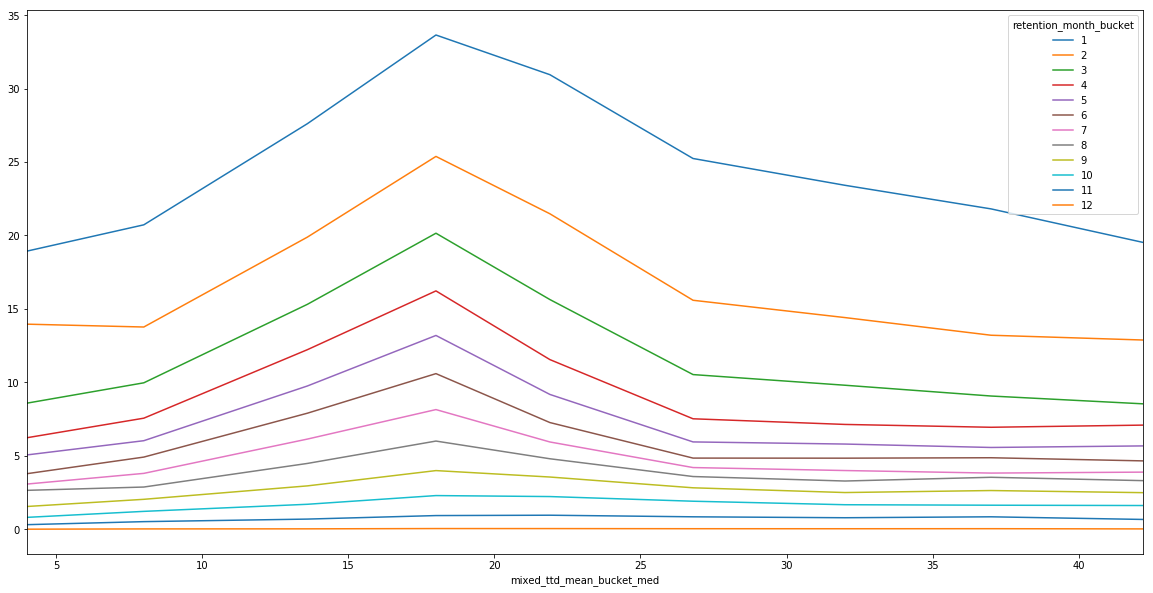

In [1338]:
df_trainning.pivot_table(columns='retention_month_bucket', values='retention_value', index='mixed_ttd_mean_bucket_med').plot(figsize=(20, 10))

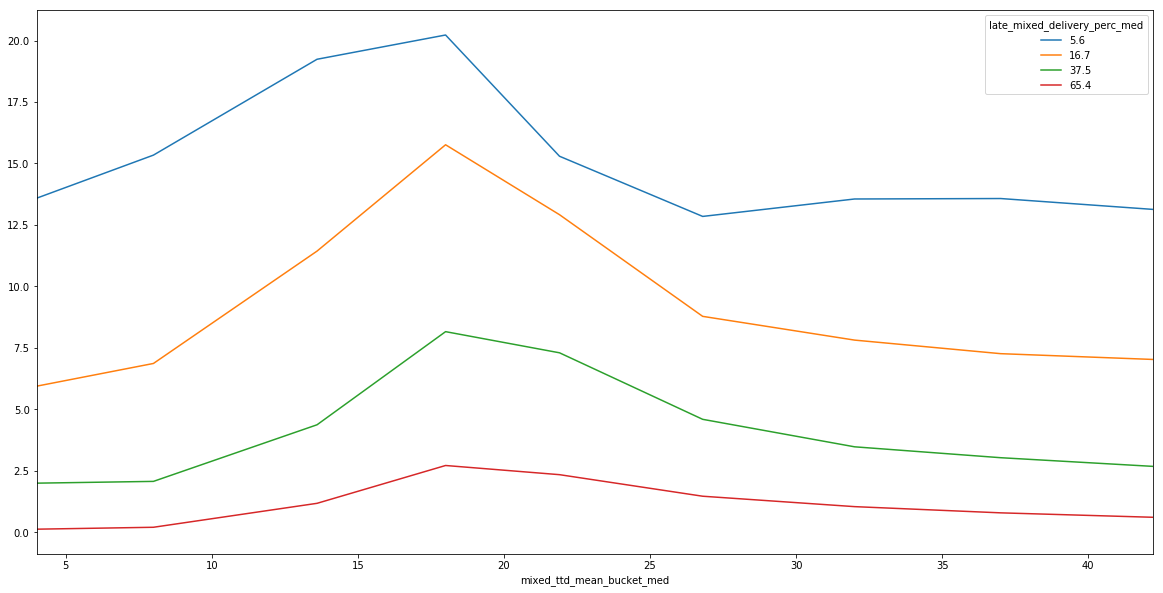

In [1340]:
df_trainning.pivot_table(columns='late_mixed_delivery_perc_med', values='retention_value', index='mixed_ttd_mean_bucket_med').plot(figsize=(20, 10))

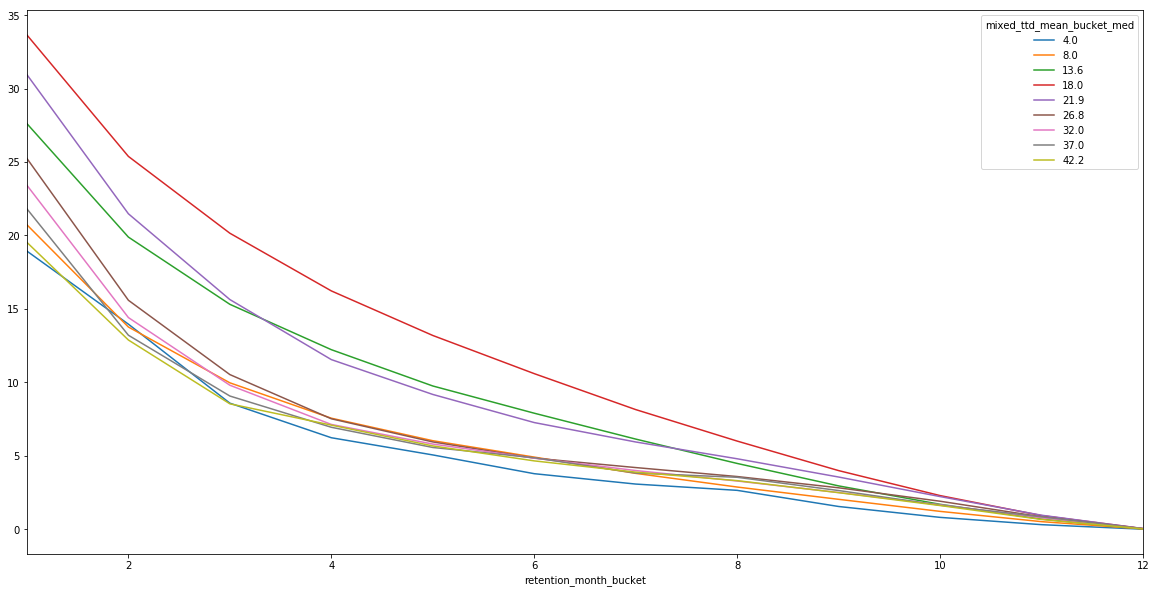

In [1341]:
df_trainning.pivot_table(columns='mixed_ttd_mean_bucket_med', values='retention_value', index='retention_month_bucket').plot(figsize=(20, 10))

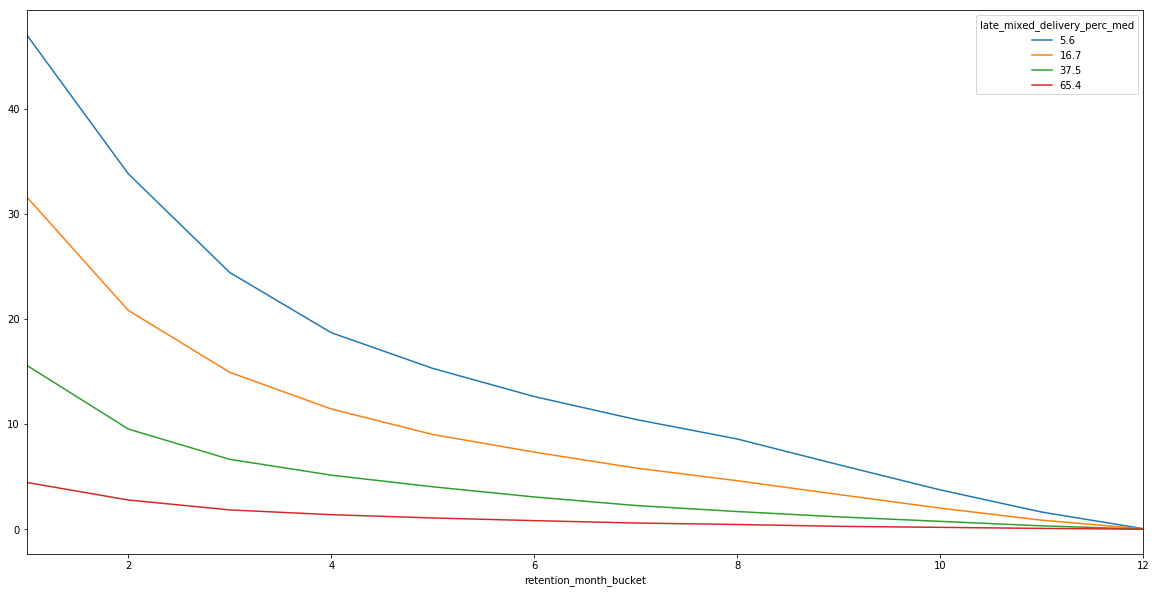

In [1342]:
df_trainning.pivot_table(columns='late_mixed_delivery_perc_med', values='retention_value', index='retention_month_bucket').plot(figsize=(20, 10))

In [5]:
def split_train_test_w_weight(df,feature_name,w,state=1,test_portion=0.3,inside_intercept=False):
    y = df.ln_retention_value
    feature = feature_name.copy()
    feature.append(w)
    X2 = df[feature]
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=test_portion, random_state=state)
    X2_train_weight = X2_train['user_cnt_m0']
    X2_test_weight = X2_test['user_cnt_m0']
    X2_train = X2_train[feature_name]
    X2_test = X2_test[feature_name]
    if inside_intercept==True: 
        X2_train['inside_intercept'] = 1
        X2_test['inside_intercept'] = 1
    return X2_train, X2_train_weight, y2_train, X2_test, X2_test_weight, y2_test

In [1373]:
X2_train, X2_train_weight, y2_train, X2_test, X2_test_weight, y2_test = split_train_test_w_weight(df_trainning,feature_name=['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med','retention_month_bucket'],w='user_cnt_m0')

In [1402]:
X2_train.head(),y2_train.head()

(     late_mixed_delivery_perc_med  mixed_ttd_mean_bucket_med  \
 300                          16.7                       18.0   
 337                          16.7                       21.9   
 238                          37.5                       21.9   
 208                          65.4                        8.0   
 127                          37.5                        8.0   
 
      retention_month_bucket  
 300                       9  
 337                      10  
 238                       7  
 208                       6  
 127                       4  , 300    1.682317
 337    1.116125
 238    1.447154
 208   -2.032558
 127    0.835948
 Name: ln_retention_value, dtype: float64)

In [1375]:
def search_linear_model(X2_train, X2_train_weight, y2_train, X2_test, X2_test_weight, y2_test, interaction_only=False, fit_intercept=True):
    
    metrics = []

    for n in range(1,4):

        x2_train_poly = PolynomialFeatures(n, include_bias=False,interaction_only=interaction_only).fit_transform(X2_train)

        poly_reg = LinearRegression(fit_intercept=fit_intercept)
        poly_reg.fit(x2_train_poly, y2_train,sample_weight=X2_train_weight)
        
        model_coef = poly_reg.coef_
        model_intercept = poly_reg.intercept_
    #     print('The poly regression model coefficient is:{}, with the intercept = {}'.format(model_coef,model_intercept))

        y2_test_predict=poly_reg.predict(PolynomialFeatures(n, include_bias=False,interaction_only=interaction_only).fit_transform(X2_test))

        
        # start to build a metics matix
        model_mse = mean_squared_error(y2_test, y2_test_predict,sample_weight=X2_test_weight)
        model_rmse =  math.sqrt(model_mse)
        model_r2 = r2_score(y2_test, y2_test_predict,sample_weight=X2_test_weight)
        adjusted_r2 = 1 - (1-model_r2)*(len(y2_test)-1)/(len(y2_test)-PolynomialFeatures(n, include_bias=False,interaction_only=interaction_only).fit_transform(X2_test).shape[1]-1)

#         metrics_dic = {'power_degree':n,'RMSE':model_rmse,'R2':model_r2,'Adjusted_R2':adjusted_r2}
#         metrics_before_transformation.append(metrics_dic)
        
        model_mse_transfer = mean_squared_error(np.exp(y2_test), np.exp(y2_test_predict),sample_weight=X2_test_weight)
        model_rmse_transfer =  math.sqrt(model_mse_transfer)
        model_r2_transfer = r2_score(np.exp(y2_test), np.exp(y2_test_predict),sample_weight=X2_test_weight)
        adjusted_r2_transfer = 1 - (1-model_r2_transfer)*(len(y2_test)-1)/(len(y2_test)-PolynomialFeatures(n, include_bias=False,interaction_only=interaction_only).fit_transform(X2_test).shape[1]-1)

        metrics_dic = {'power_degree':n,'RMSE':model_rmse,'R2':model_r2,'Adjusted_R2':adjusted_r2, 'RMSE_transfer':model_rmse_transfer,'R2_transfer':model_r2_transfer,'Adjusted_R2_transfer':adjusted_r2_transfer}
        metrics.append(metrics_dic)
        
    
    metrics_df = pd.DataFrame(metrics)
    metrics_df.set_index('power_degree',inplace=True)
    
    return metrics_df

              Adjusted_R2  Adjusted_R2_transfer        R2  R2_transfer  \
power_degree                                                             
1                0.794495             -0.431172  0.799274    -0.397889   
2                0.886916              0.820817  0.894806     0.833318   
3                0.949832              0.864208  0.957221     0.884208   

                  RMSE  RMSE_transfer  
power_degree                           
1             0.956098      15.892523  
2             0.692144       5.487827  
3             0.441383       4.573991  


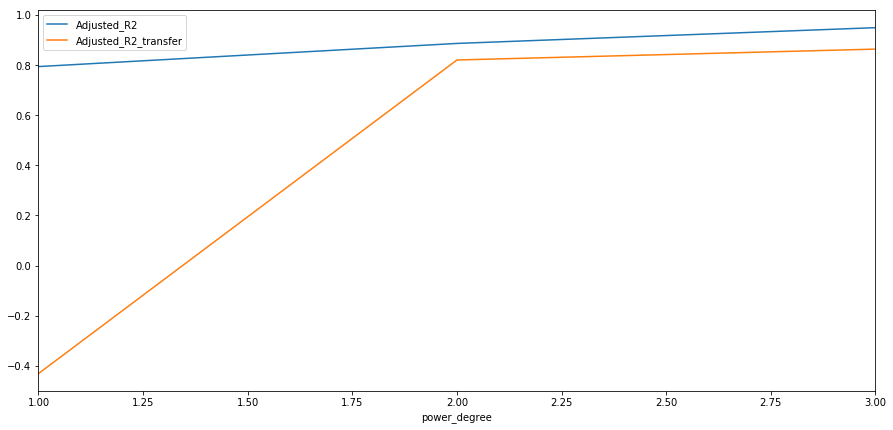

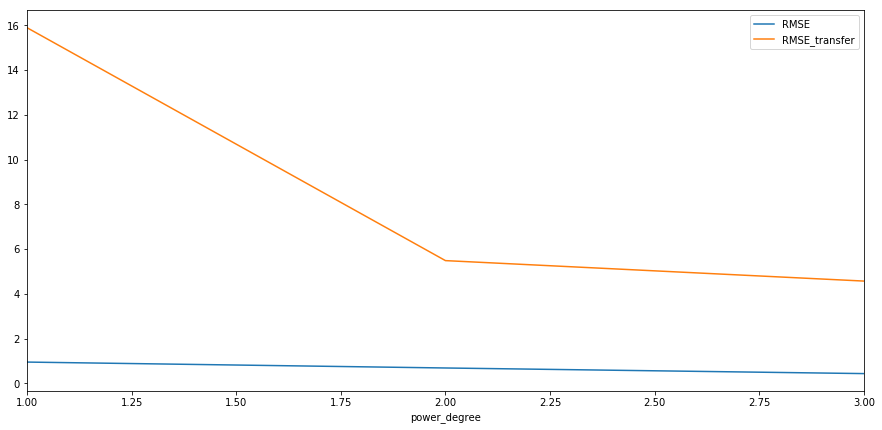

In [1376]:
interaction_only=False
fit_intercept = True
metrics_df = search_linear_model(X2_train, X2_train_weight, y2_train, X2_test, X2_test_weight, y2_test, interaction_only=interaction_only, fit_intercept=fit_intercept)
metrics_df[['Adjusted_R2','Adjusted_R2_transfer']].plot(figsize=(15, 7))
metrics_df[['RMSE','RMSE_transfer']].plot(figsize=(15, 7))
print(metrics_df)

In [274]:
# metrics_df2 = fit_linear_model(X2_train, X2_train_weight, y2_train, X2_test, X2_test_weight, y2_test, interaction_only=True)
# metrics_df2[['Adjusted_R2','Adjusted_R2_transfer','R2','R2_transfer']].plot(figsize=(15, 7))
# metrics_df2[['RMSE','RMSE_transfer']].plot(figsize=(15, 7))
# print(metrics_df2)

In [1377]:
def fit_and_pred_model(X2_train, X2_train_weight, y2_train, X2_test, X2_test_weight, y2_test, d=1, interaction_only=False,bins='auto',fit_intercept=True): 

#     ttd_bucket = sorted(list(set(df_base2.mixed_ttd_mean_bucket_med)))

    poly = PolynomialFeatures(d, include_bias=False,interaction_only=interaction_only)
    x2_train_poly = poly.fit_transform(X2_train)
    poly_feature_name = poly.get_feature_names(X2_train.columns)
#     print('The polynomial features name are:{}'.format(poly_feature_name))

    poly_reg = LinearRegression(fit_intercept=fit_intercept)
    poly_reg.fit(x2_train_poly, y2_train,sample_weight=X2_train_weight)
    
    model_coef = pd.DataFrame(zip(poly_feature_name,poly_reg.coef_),columns=['coef_name','coef_value'])
    print(model_coef)
    
    y2_test_predict=poly_reg.predict(PolynomialFeatures(d, include_bias=False,interaction_only=interaction_only).fit_transform(X2_test))
    
    (np.exp(y2_test) - np.exp(y2_test_predict)).hist(grid = False, color = 'blue',bins=bins,figsize=(16, 8))
    plt.title("Model Residuals")
    plt.xlim(-20,20)
    plt.show()
    
    return poly_reg, poly_feature_name

                                           coef_name  coef_value
0                       late_mixed_delivery_perc_med   -0.043115
1                          mixed_ttd_mean_bucket_med    0.142079
2                             retention_month_bucket    0.231615
3                     late_mixed_delivery_perc_med^2   -0.000323
4  late_mixed_delivery_perc_med mixed_ttd_mean_bu...    0.001242
5  late_mixed_delivery_perc_med retention_month_b...   -0.000821
6                        mixed_ttd_mean_bucket_med^2   -0.004468
7   mixed_ttd_mean_bucket_med retention_month_bucket    0.003184
8                           retention_month_bucket^2   -0.055573


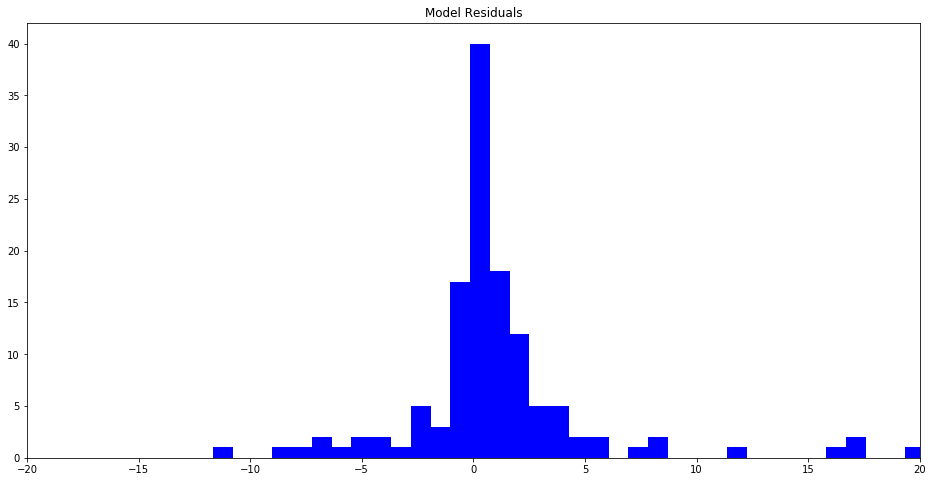

In [1397]:
d = 2
interaction_only=False
fit_intercept=True
poly_reg, poly_feature_name = fit_and_pred_model(X2_train, X2_train_weight, y2_train, X2_test, X2_test_weight, y2_test, d=d, interaction_only=interaction_only)

Text(0.5,1,'The retention graph with different ttd bucket over month')

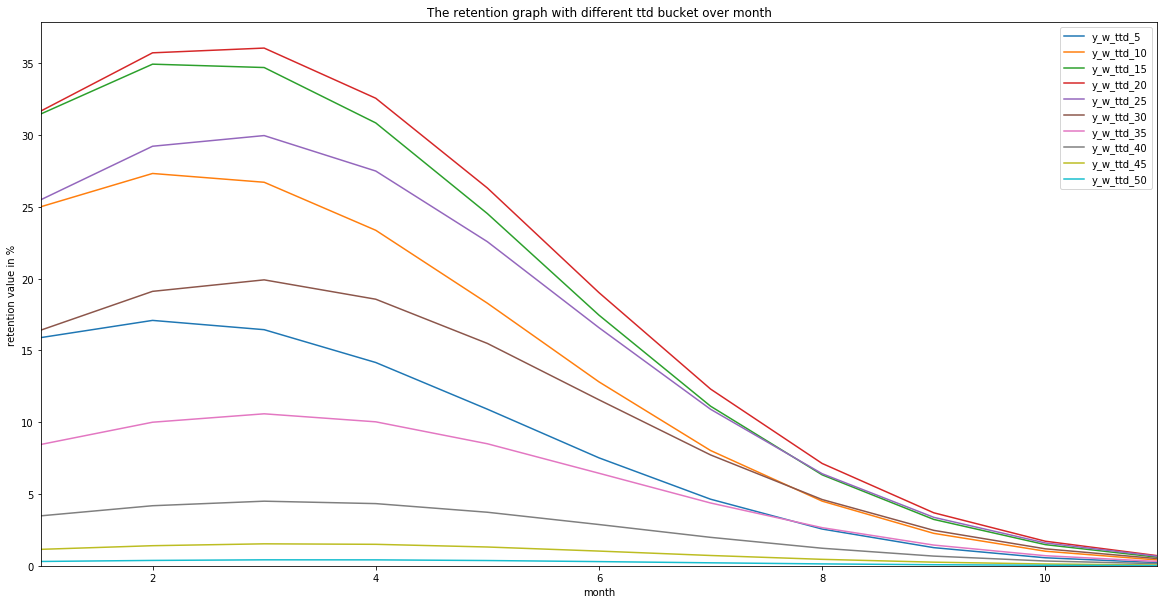

In [1398]:
ttd = list(np.arange(5, 55, 5))
y_name = ['y_w_ttd_' + str(i) for i in ttd]

df_simulated = pd.DataFrame(columns=y_name)

# x is month from 1-12
df_simulated['x'] = list(np.arange(1, 12, 1))
late_delivery_perc = 10

for i,c in zip(ttd,y_name):

    simulated_month = df_simulated['x']
    simulated_ttd = [i]*len(simulated_month)
    simulated_late_delivery_perc = [late_delivery_perc] *len(simulated_month)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_late_delivery_perc,simulated_ttd,simulated_month)),columns=['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]= np.exp(poly_reg.predict(PolynomialFeatures(d, include_bias=False,interaction_only=interaction_only).fit_transform(X_df)))

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('month')
plt.ylabel('retention value in %')
plt.ylim(0,)
plt.xlim(1,)
plt.title('The retention graph with different ttd bucket over month')

Text(0.5,1,'The retention graph with different late_delivery_perc_bucket over month')

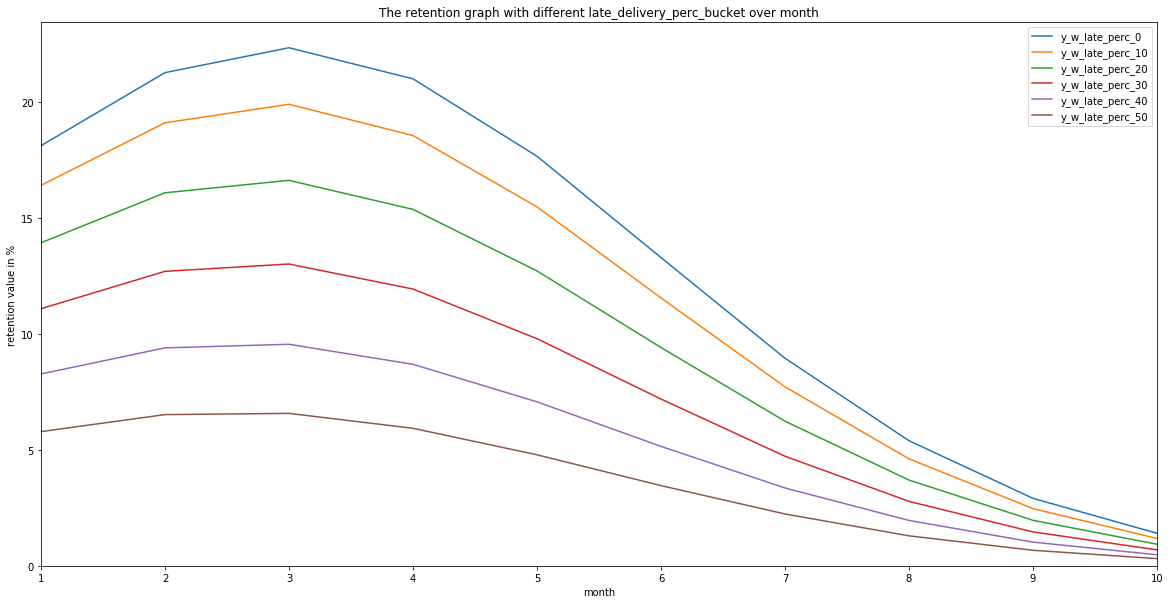

In [1399]:
late_perc = list(np.arange(0, 60, 10))
y_name = ['y_w_late_perc_' + str(i) for i in late_perc]

df_simulated = pd.DataFrame(columns=y_name)

# x is month from 1-12
df_simulated['x'] = list(np.arange(1, 11, 1))
ttd = 30

for i,c in zip(late_perc,y_name):

    simulated_month = df_simulated['x']
    simulated_ttd = [ttd]*len(simulated_month)
    simulated_late_delivery_perc = [i] *len(simulated_month)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_late_delivery_perc,simulated_ttd,simulated_month)),columns=['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]= np.exp(poly_reg.predict(PolynomialFeatures(d, include_bias=False,interaction_only=interaction_only).fit_transform(X_df)))

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('month')
plt.ylabel('retention value in %')
plt.ylim(0,)
plt.xlim(1,)
plt.title('The retention graph with different late_delivery_perc_bucket over month')

Text(0.5,1,'The retention graph with different late_delivery_perc over ttd')

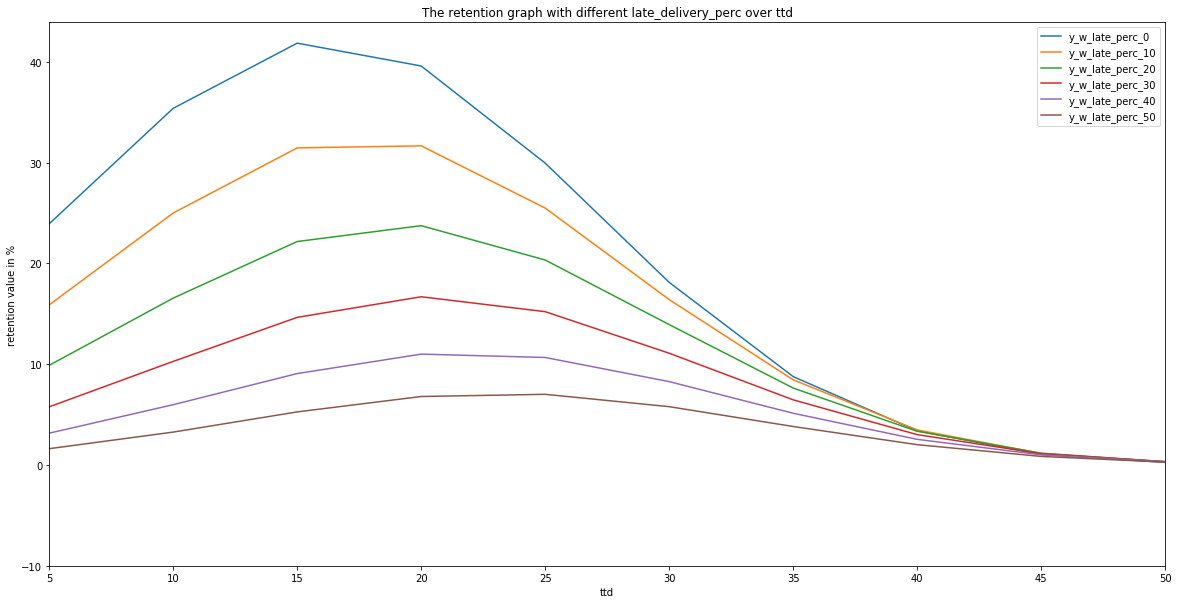

In [1400]:
late_perc = list(np.arange(0, 60, 10))
y_name = ['y_w_late_perc_' + str(i) for i in late_perc]

df_simulated = pd.DataFrame(columns=y_name)

# x is ttd
df_simulated['x'] = list(np.arange(5, 55, 5))
month = 1

for i,c in zip(late_perc,y_name):

    simulated_ttd = df_simulated['x']
    simulated_month = [month]*len(simulated_ttd)
    simulated_late_delivery_perc = [i] *len(simulated_ttd)

    X_df = pd.DataFrame(list(zip(simulated_late_delivery_perc,simulated_ttd,simulated_month)),columns=['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]=np.exp(poly_reg.predict(PolynomialFeatures(d, include_bias=False,interaction_only=interaction_only).fit_transform(X_df)))

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('ttd')
plt.ylabel('retention value in %')
plt.ylim(-10,)
plt.xlim(5,)
plt.title('The retention graph with different late_delivery_perc over ttd')

Text(0.5,1,'The retention graph with different month bucket over late_delivery_perc')

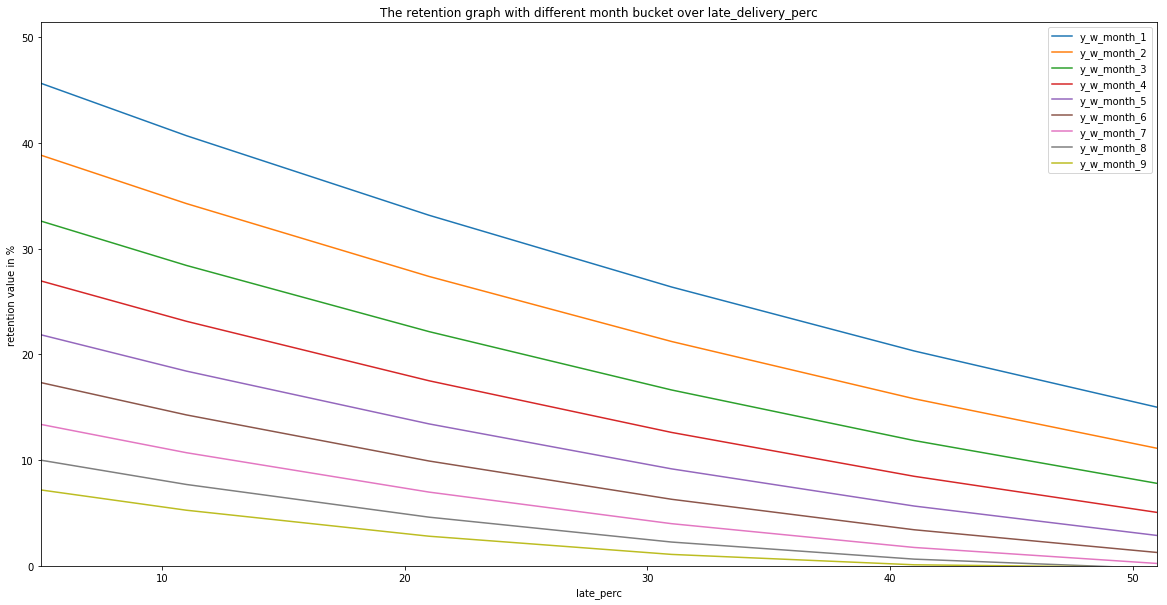

In [1401]:
#set up the groups
month =  list(np.arange(1, 10, 1))
y_name = ['y_w_month_' + str(i) for i in month]

#initiate the DF
df_simulated = pd.DataFrame(columns=y_name)

# x axis is late_delivery_perc
df_simulated['x'] = list(np.arange(1, 60, 10))

ttd = 20

# X['sqrt_rentention_month_bucket'] = np.sqrt(X['rentention_month_bucket'])

for i,c in zip(month,y_name):

    simulated_late_delivery_perc = df_simulated['x']
    simulated_month = [i]*len(simulated_late_delivery_perc)
    simulated_ttd = [ttd] *len(simulated_late_delivery_perc)

    X_df = pd.DataFrame(list(zip(simulated_late_delivery_perc,simulated_ttd,simulated_month)),columns=['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]=func_exp_d2(X_df, *popt_d2)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('late_perc')
plt.ylabel('retention value in %')
plt.ylim(-0,)
plt.xlim(5,)
plt.title('The retention graph with different month bucket over late_delivery_perc')

## without avg_gmv

In [792]:
feature0 = ['mixed_ttd_mean_bucket_med']
df_trainning2 = prepare_base_date(df,feature0)

df_trainning2.loc[df_trainning2.retention_value==0,'retention_value'] = 0.001
df_trainning2['ln_retention_value'] = np.log(df_trainning2.retention_value)
df_trainning2.head()

,mixed_ttd_mean_bucket_med,user_cnt_m0,retention_month_bucket,user_cnt,retention_value,ln_retention_value
0,4.0,345222,1,26312,7.622,2.031039
1,8.0,528270,1,69962,13.244,2.583545
2,13.6,1341258,1,254516,18.976,2.943175
3,18.0,2259702,1,582849,25.793,3.250103
4,21.9,1251610,1,330044,26.370,3.272227


In [210]:
df_trainning2.shape, df_trainning.shape

((108, 6), (1404, 7))

In [8]:
X2_train, X2_train_weight, y2_train, X2_test, X2_test_weight, y2_test = split_train_test_w_weight(df_trainning,feature_name=['mixed_ttd_mean_bucket_med','retention_month_bucket'],w='user_cnt_m0',inside_intercept=False)

In [9]:
X2_train.head(),X2_train.shape

(     mixed_ttd_mean_bucket_med  retention_month_bucket
 593                       42.2                       6
 220                       21.9                       2
 821                       13.6                       8
 34                        37.0                       1
 85                        21.9                       1, (982, 2))

              Adjusted_R2  Adjusted_R2_transfer        R2  R2_transfer  \
power_degree                                                             
1                0.691560              0.325640  0.693025     0.328844   
2                0.810985              0.502823  0.813229     0.508728   
3                0.872820              0.727030  0.875539     0.732866   
4                0.893036              0.751347  0.896593     0.759616   
5                0.901414              0.799011  0.906098     0.808559   
6                0.902957              0.767120  0.909180     0.782055   
7                0.900819              0.759679  0.909065     0.779658   
8                0.896347              0.739203  0.907180     0.766460   
9                0.879945              0.664958  0.895344     0.707933   

                  RMSE  RMSE_transfer  
power_degree                           
1             1.101551       6.304754  
2             0.859225       5.394082  
3             0.701406   

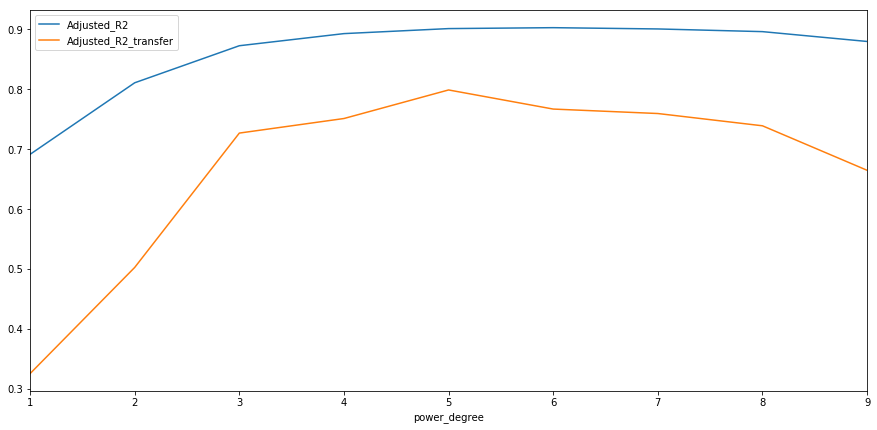

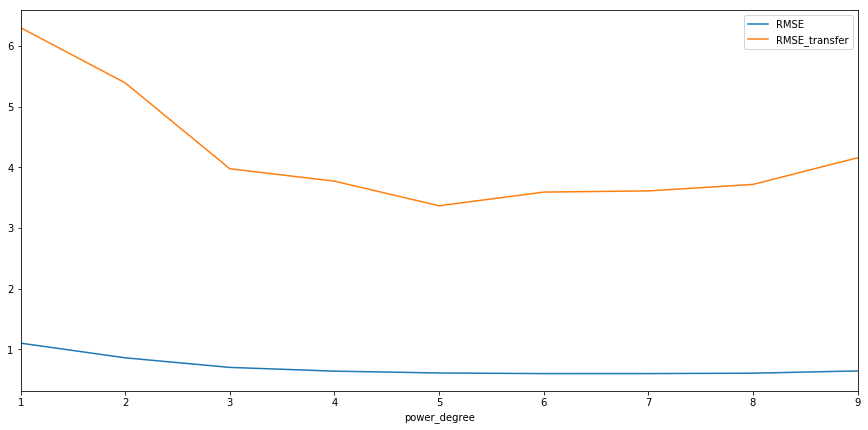

In [415]:
interaction_only=False
fit_intercept=True
metrics_df = search_linear_model(X2_train, X2_train_weight, y2_train, X2_test, X2_test_weight, y2_test, interaction_only=interaction_only,fit_intercept=fit_intercept)
metrics_df[['Adjusted_R2','Adjusted_R2_transfer']].plot(figsize=(15, 7))
metrics_df[['RMSE','RMSE_transfer']].plot(figsize=(15, 7))
print(metrics_df)

                                          coef_name  coef_value
0                         mixed_ttd_mean_bucket_med    0.219115
1                            retention_month_bucket    0.229202
2                       mixed_ttd_mean_bucket_med^2   -0.005627
3  mixed_ttd_mean_bucket_med retention_month_bucket    0.004244
4                          retention_month_bucket^2   -0.058897


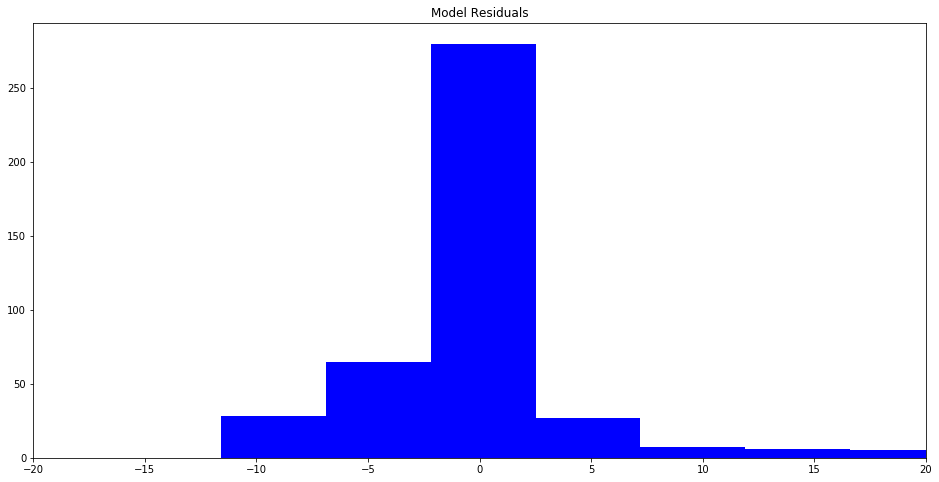

In [416]:
d = 2
interaction_only = False
fit_intercept = True
poly_reg, poly_feature_name = fit_and_pred_model(X2_train, X2_train_weight, y2_train, X2_test, X2_test_weight, y2_test, d=d, interaction_only=interaction_only, bins=10,fit_intercept=fit_intercept)

Text(0.5,1,'The retention graph with different gmv bucket over month')

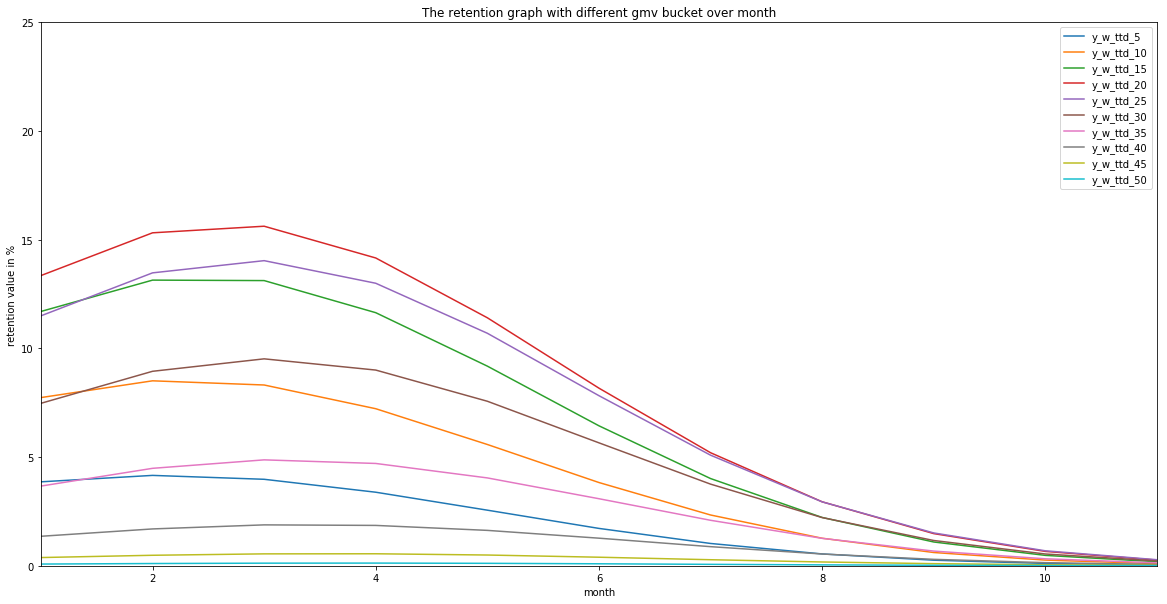

In [419]:
ttd = list(np.arange(5, 55, 5))
y_name = ['y_w_ttd_' + str(i) for i in ttd]

df_simulated = pd.DataFrame(columns=y_name)

# x is month from 1-12
df_simulated['x'] = list(np.arange(1, 12, 1))

for i,c in zip(ttd,y_name):

    simulated_month = df_simulated['x']
    simulated_ttd = [i]*len(simulated_month)
#     inside_intercept = [1]*len(simulated_month)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]=np.exp(poly_reg.predict(PolynomialFeatures(d, include_bias=False,interaction_only=interaction_only).fit_transform(X_df)))

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('month')
plt.ylabel('retention value in %')
plt.ylim(0,25)
plt.xlim(1,)
plt.title('The retention graph with different gmv bucket over month')

Text(0.5,1,'The retention graph with different gmv bucket over ttd')

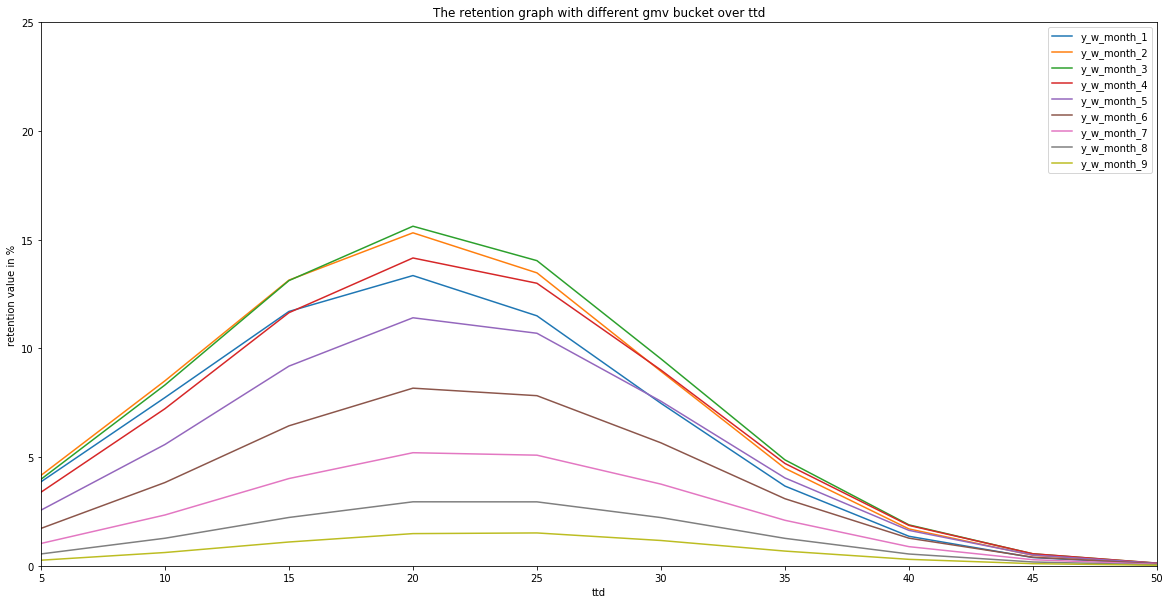

In [420]:
month =  list(np.arange(1, 10, 1))
y_name = ['y_w_month_' + str(i) for i in month]

df_simulated = pd.DataFrame(columns=y_name)

# x is ttd
df_simulated['x'] = list(np.arange(5, 55, 5))

# X['sqrt_rentention_month_bucket'] = np.sqrt(X['rentention_month_bucket'])

for i,c in zip(month,y_name):

    simulated_ttd = df_simulated['x']
    simulated_month = [i]*len(simulated_ttd)
    inside_intercept = [1]*len(simulated_ttd)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]=np.exp(poly_reg.predict(PolynomialFeatures(d, include_bias=False,interaction_only=interaction_only).fit_transform(X_df)))

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('ttd')
plt.ylabel('retention value in %')
plt.ylim(0,25)
plt.xlim(5,)
plt.title('The retention graph with different gmv bucket over ttd')

# Explore on optimization package(least square) to fit non-linear regression function

In [340]:
def split_train_test_w_weight_2(df,feature_name,w,state=1,test_portion=0.3,inside_intercept=False):
    y = df.retention_value
    
    if w:
        
        feature = feature_name.copy()
        feature.append(w)
        X2 = df[feature]
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=test_portion, random_state=state)
        X2_train_weight = X2_train['user_cnt_m0']
        X2_test_weight = X2_test['user_cnt_m0']
        X2_train = X2_train[feature_name]
        X2_test = X2_test[feature_name]
        if inside_intercept==True: 
            X2_train['inside_intercept'] = 1
            X2_test['inside_intercept'] = 1
            
        return X2_train, X2_train_weight, y2_train, X2_test, X2_test_weight, y2_test
    
    else: 
        feature = feature_name.copy()
        X2 = df[feature]
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=test_portion, random_state=state)
        if inside_intercept==True: 
            X2_train['inside_intercept'] = 1
            X2_test['inside_intercept'] = 1
#         X2_train_weight=None
#         X2_test_weight = None
    return X2_train, y2_train, X2_test, y2_test

In [376]:
# df_trainning2 = df_trainning[['mixed_ttd_mean_bucket_med','retention_month_bucket','retention_value']]
X2_train, X2_train_weight, y2_train, X2_test, X2_test_weight, y2_test = split_train_test_w_weight_2(df_trainning,feature_name=['mixed_ttd_mean_bucket_med','retention_month_bucket'],w='user_cnt_m0',inside_intercept=False)

In [377]:
X2_train.shape, X2_test.shape

((982, 2), (422, 2))

### explore log function

In [367]:
def func_log_d1(X, a, b, c,d,e,f,g,h,i):
    ttd = X['mixed_ttd_mean_bucket_med']
    month = X['retention_month_bucket']
    inter = ttd * month
    ttd2 = ttd**2
    month2 = month**2
    return -a * np.log(b * ttd + c*month + d*ttd2 + e*month2) + f*ttd + g*month + h*ttd2 + i * month2

p0 = [1,1,1,1,1,1,1,1,1]

In [368]:
popt_log_d1, pcov_log_d1 = curve_fit(func_log_d1, X2_train, y2_train, p0=p0)
popt_log_d1,pcov_log_d1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


(array([-1.01347334e+01, -4.54807239e-01,  1.67871690e+00,  2.96783421e-01,
        -7.18317200e-02, -1.46297175e+00, -4.23812635e+00,  9.29375239e-03,
         2.17564544e-01]),
 array([[ 1.28764274e+02, -4.52728354e+01,  4.99691394e+01,
          1.18425229e+01, -1.91262784e+00,  1.49848078e+01,
          2.46835324e+00, -1.23573248e-01, -1.26277548e-01],
        [-4.52728354e+01,  1.65512496e+01, -1.81735503e+01,
         -4.27488774e+00,  7.14134609e-01, -5.08236905e+00,
         -7.46459784e-01,  4.06847968e-02,  3.46837042e-02],
        [ 4.99691394e+01, -1.81735503e+01,  2.02456881e+01,
          4.68414684e+00, -8.07456831e-01,  5.69506567e+00,
          7.41453704e-01, -4.62780944e-02, -3.14229796e-02],
        [ 1.18425229e+01, -4.27488774e+00,  4.68414684e+00,
          1.11223053e+00, -1.81724215e-01,  1.33579183e+00,
          2.06563446e-01, -1.07112960e-02, -9.96391446e-03],
        [-1.91262784e+00,  7.14134609e-01, -8.07456831e-01,
         -1.81724215e-01,  3.38390160

In [191]:
y2_test_pred = func_log_d1(X2_test, *popt_log_d1)
model_mse = mean_squared_error(y2_test, y2_test_pred)
model_rmse =  math.sqrt(model_mse)
model_r2 = r2_score(y2_test, y2_test_pred)
adjusted_r2 = 1 - (1-model_r2)*(len(y2_test)-1)/(len(y2_test)-PolynomialFeatures(1, include_bias=False,interaction_only=False).fit_transform(X2_test).shape[1]-1)
model_rmse,model_r2,adjusted_r2

(4.520119047152306, 0.476846483485003, 0.4743493306615424)

In [192]:
chisquare(y2_test, f_exp=y2_test_pred)

Power_divergenceResult(statistic=590.5298642792226, pvalue=8.705149767092117e-08)

(0, 40)

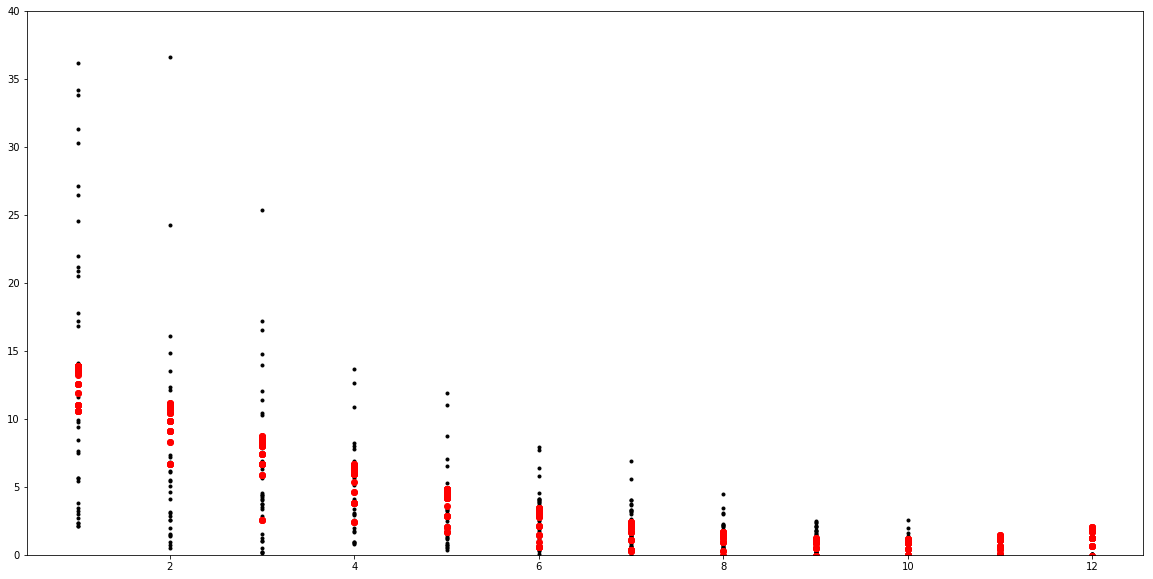

In [193]:
plt.figure(figsize=(20,10))
plt.plot(X2_test['retention_month_bucket'], y2_test, 'k.', label="Original Noised Data")
plt.plot(X2_test['retention_month_bucket'], y2_test_pred, 'ro', label="Fitted Curve")
plt.ylim(0,40)

Text(0.5,1,'The retention graph with different gmv bucket over month')

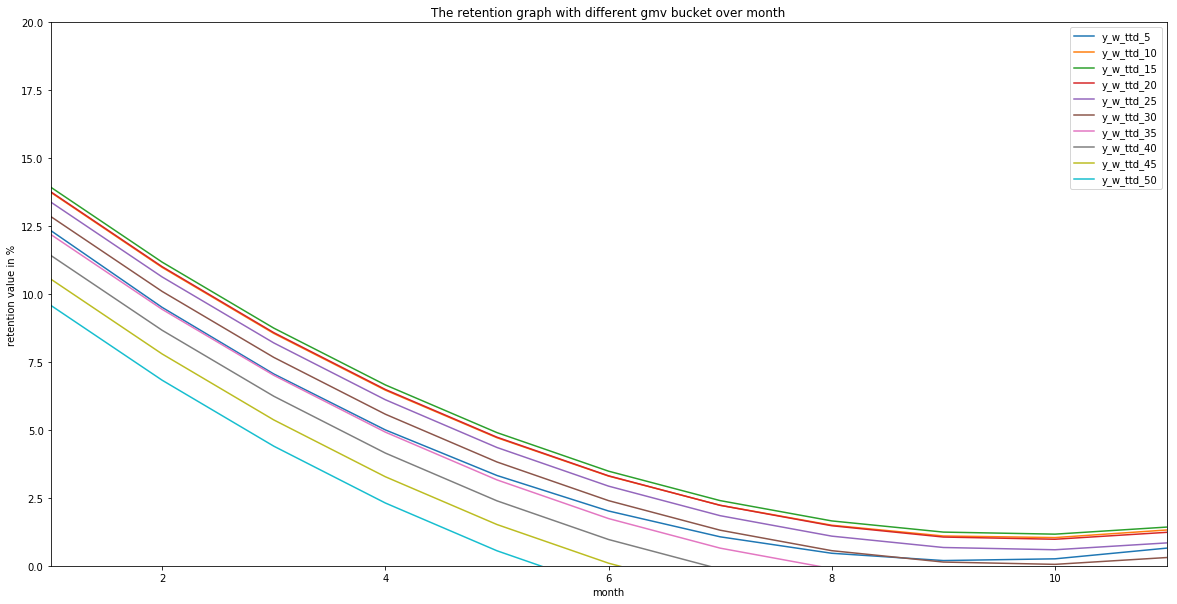

In [194]:
ttd = list(np.arange(5, 55, 5))
y_name = ['y_w_ttd_' + str(i) for i in ttd]

df_simulated = pd.DataFrame(columns=y_name)

# x is month from 1-12
df_simulated['x'] = list(np.arange(1, 12, 1))

for i,c in zip(ttd,y_name):

    simulated_month = df_simulated['x']
    simulated_ttd = [i]*len(simulated_month)
#     inside_intercept = [1]*len(simulated_month)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]= func_log_d1(X_df, *popt_log_d1) 

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('month')
plt.ylabel('retention value in %')
plt.ylim(0,20)
plt.xlim(1,)
plt.title('The retention graph with different gmv bucket over month')

### explore exp function

In [378]:
def func_exp_d1(X, a, b, c, d, e):
    ttd = X['mixed_ttd_mean_bucket_med']
    month = X['retention_month_bucket']
#     return b* np.exp(-c * ttd - d*month - e*ttd*month) + f*ttd + g*month + h*ttd*month
    return a* np.exp(-b * ttd - c*month) + d*ttd + e*month

In [379]:
popt_d1, pcov_d1 = curve_fit(func_exp_d1, X2_train, y2_train)
popt_d1,pcov_d1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


(array([ 2.49052806e+01,  5.57181043e-03,  4.10883061e-01, -9.98139174e-03,
         5.69601684e-02]),
 array([[ 2.98279591e+00,  3.28903017e-03,  3.15410280e-02,
          9.17843713e-03, -6.57914368e-03],
        [ 3.28903017e-03,  6.89718127e-06,  1.63511177e-05,
          2.36229052e-05, -4.62629748e-05],
        [ 3.15410280e-02,  1.63511177e-05,  6.90533702e-04,
          1.14978984e-04,  1.18118601e-04],
        [ 9.17843713e-03,  2.36229052e-05,  1.14978984e-04,
          1.86997776e-04, -3.77009119e-04],
        [-6.57914368e-03, -4.62629748e-05,  1.18118601e-04,
         -3.77009119e-04,  1.30696762e-03]]))

In [380]:
y2_test_pred = func_exp_d1(X2_test, *popt_d1)
model_mse = mean_squared_error(y2_test, y2_test_pred)
model_rmse =  math.sqrt(model_mse)
model_r2 = r2_score(y2_test, y2_test_pred)
adjusted_r2 = 1 - (1-model_r2)*(len(y2_test)-1)/(len(y2_test)-PolynomialFeatures(1, include_bias=False,interaction_only=False).fit_transform(X2_test).shape[1]-1)
model_rmse,model_r2,adjusted_r2

(4.6789394921359015, 0.43943721690261106, 0.4367614995608574)

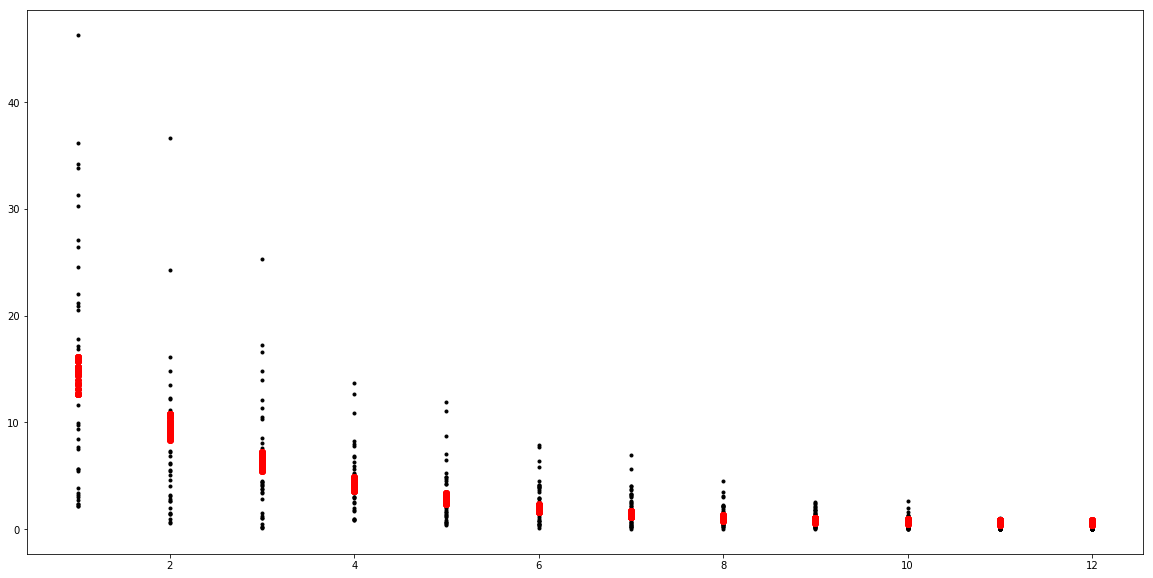

In [381]:
plt.figure(figsize=(20,10))
plt.plot(X2_test['retention_month_bucket'], y2_test, 'k.', label="Original Noised Data")
plt.plot(X2_test['retention_month_bucket'], y2_test_pred, 'ro', label="Fitted Curve")

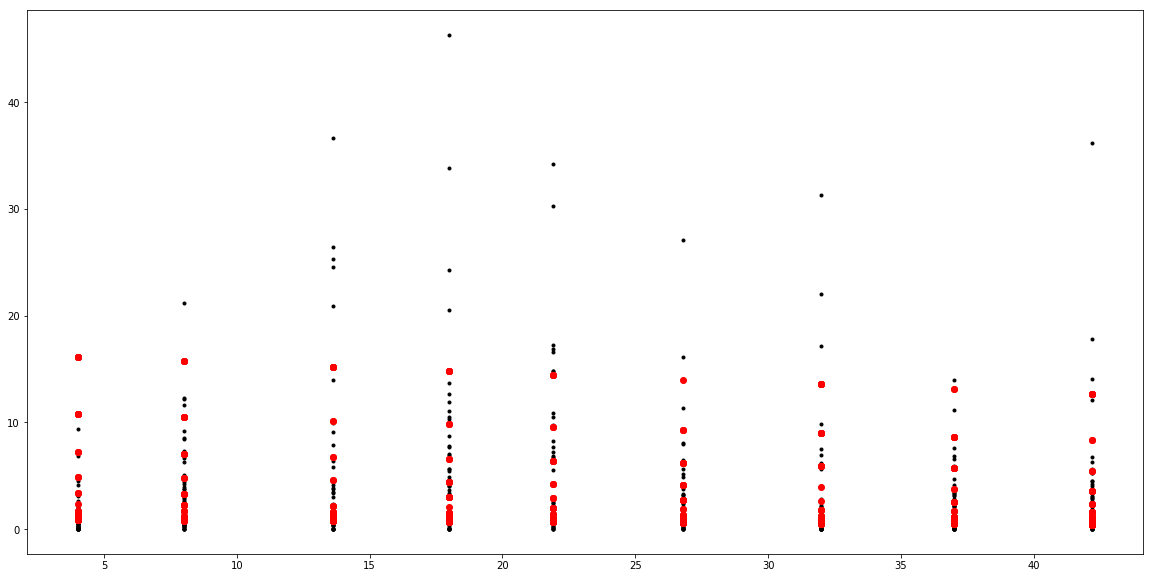

In [382]:
plt.figure(figsize=(20,10))
plt.plot(X2_test['mixed_ttd_mean_bucket_med'], y2_test, 'k.', label="Original Noised Data")
plt.plot(X2_test['mixed_ttd_mean_bucket_med'], y2_test_pred, 'ro', label="Fitted Curve")

Text(0.5,1,'The retention graph with different gmv bucket over month')

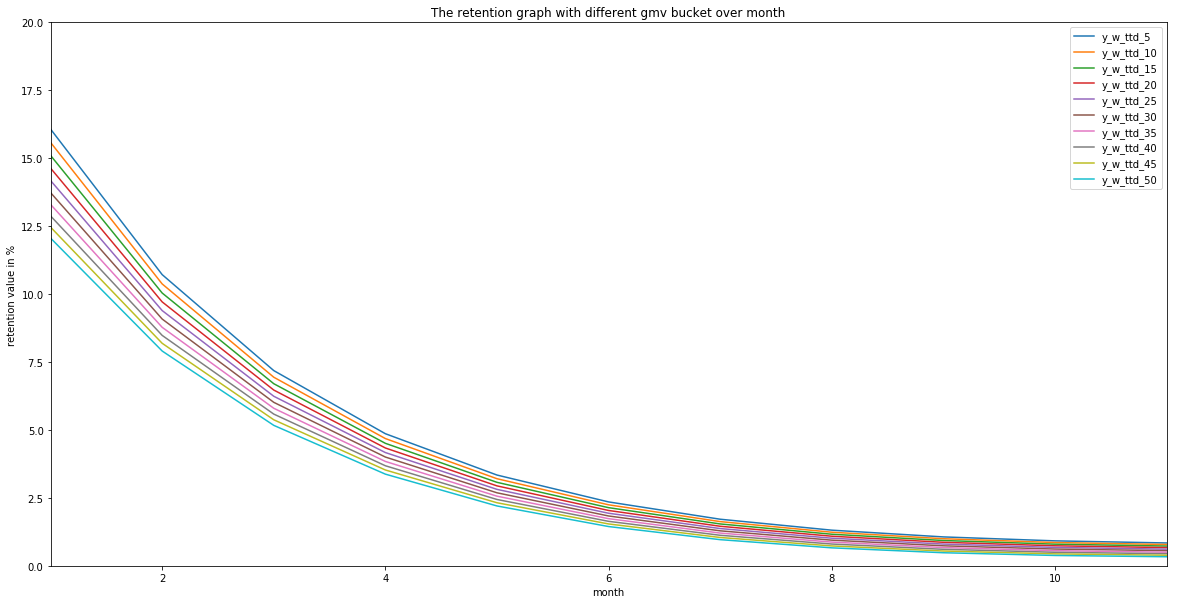

In [383]:
ttd = list(np.arange(5, 55, 5))
y_name = ['y_w_ttd_' + str(i) for i in ttd]

df_simulated = pd.DataFrame(columns=y_name)

# x is month from 1-12
df_simulated['x'] = list(np.arange(1, 12, 1))

for i,c in zip(ttd,y_name):

    simulated_month = df_simulated['x']
    simulated_ttd = [i]*len(simulated_month)
#     inside_intercept = [1]*len(simulated_month)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]= func_exp_d1(X_df, *popt_d1)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('month')
plt.ylabel('retention value in %')
plt.ylim(0,20)
plt.xlim(1,)
plt.title('The retention graph with different gmv bucket over month')

Text(0.5,1,'The retention graph with different gmv bucket over ttd')

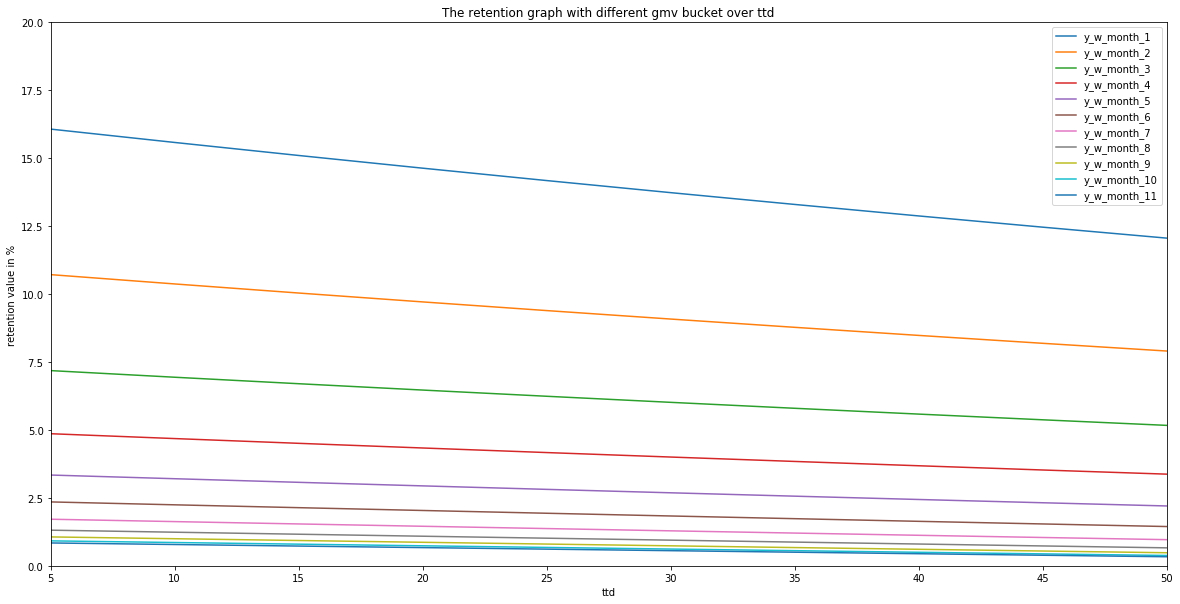

In [384]:
month =  list(np.arange(1, 12, 1))
y_name = ['y_w_month_' + str(i) for i in month]

df_simulated = pd.DataFrame(columns=y_name)

# x is ttd
df_simulated['x'] = list(np.arange(5, 55, 5))

# X['sqrt_rentention_month_bucket'] = np.sqrt(X['rentention_month_bucket'])

for i,c in zip(month,y_name):

    simulated_ttd = df_simulated['x']
    simulated_month = [i]*len(simulated_ttd)
    inside_intercept = [1]*len(simulated_ttd)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]=func_exp_d1(X_df, *popt_d1)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('ttd')
plt.ylabel('retention value in %')
plt.ylim(0,20)
plt.xlim(5,)
plt.title('The retention graph with different gmv bucket over ttd')

### incorporate with weighted samples

In [391]:
def simulated_sample_data_w_weight(df,full_list,weigt_name):
    x_y_name = full_list
    w = weigt_name
    x_y_w = x_y_name.copy()
    x_y_w.append(w)
    
    df_all = df[x_y_w]

    df_w = df_all[w]
    w_total = df_w.sum()
    stand_w = round(10000*df_w/w_total,0).astype(int)

    df_final = pd.DataFrame(columns=x_y_name)

    for i in range(len(stand_w)) : 
        df_temp = df_all.loc[i, x_y_name]
        df_w = stand_w[i]
        df_temp = pd.DataFrame([df_temp]*df_w)

        df_final = pd.concat([df_final,df_temp], ignore_index=True)
    return df_final

In [392]:
df = df_trainning
weight_name = 'user_cnt_m0'
full_list=['mixed_ttd_mean_bucket_med','retention_month_bucket','retention_value']
df_weight = simulated_sample_data_w_weight(df=df,full_list=full_list,weigt_name=weight_name)

In [470]:
df_weight.shape

(9996, 3)

In [471]:
X2_train, y2_train, X2_test, y2_test = split_train_test_w_weight_2(df_weight,feature_name=['mixed_ttd_mean_bucket_med','retention_month_bucket'],w=None,inside_intercept=False)
X2_train.shape,X2_test.shape,y2_train.shape,y2_test.shape

In [473]:
popt_d1, pcov_d1 = curve_fit(func_exp_d1, X2_train, y2_train)
popt_d1,pcov_d1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


(array([ 2.19557728e+01, -1.35793057e-02,  3.42113102e-01,  8.53475719e-02,
        -1.05530792e-01]),
 array([[ 2.17289971e-01,  4.43881138e-04,  1.76423926e-03,
          1.97598728e-03, -1.76504736e-03],
        [ 4.43881138e-04,  1.27926010e-06,  2.47407485e-06,
          7.31325258e-06, -1.01329883e-05],
        [ 1.76423926e-03,  2.47407485e-06,  4.37857769e-05,
          3.87805817e-05, -1.81433587e-05],
        [ 1.97598728e-03,  7.31325258e-06,  3.87805817e-05,
          1.07626964e-04, -1.44390589e-04],
        [-1.76504736e-03, -1.01329883e-05, -1.81433587e-05,
         -1.44390589e-04,  2.74376479e-04]]))

In [474]:
y2_test_pred = func_exp_d1(X2_test, *popt_d1)
model_mse = mean_squared_error(y2_test, y2_test_pred)
model_rmse =  math.sqrt(model_mse)
model_r2 = r2_score(y2_test, y2_test_pred)
adjusted_r2 = 1 - (1-model_r2)*(len(y2_test)-1)/(len(y2_test)-PolynomialFeatures(1, include_bias=False,interaction_only=False).fit_transform(X2_test).shape[1]-1)
model_rmse,model_r2,adjusted_r2

(3.9409022123098203, 0.7122581909679995, 0.712066106983332)

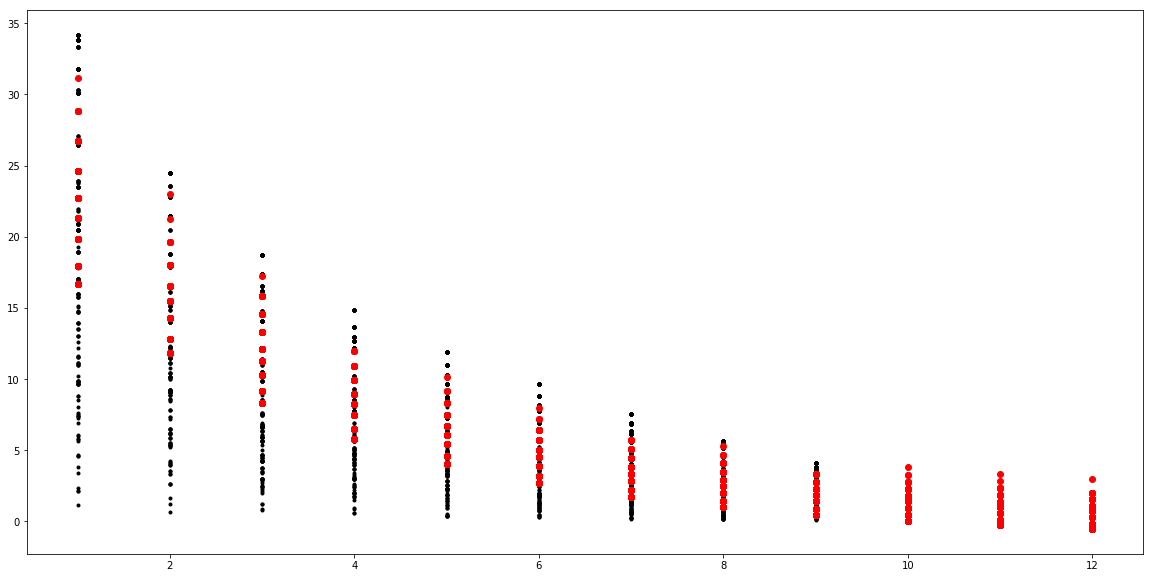

In [475]:
plt.figure(figsize=(20,10))
plt.plot(X2_test['retention_month_bucket'], y2_test, 'k.', label="Original Noised Data")
plt.plot(X2_test['retention_month_bucket'], y2_test_pred, 'ro', label="Fitted Curve")

Text(0.5,1,'The retention graph with different gmv bucket over month')

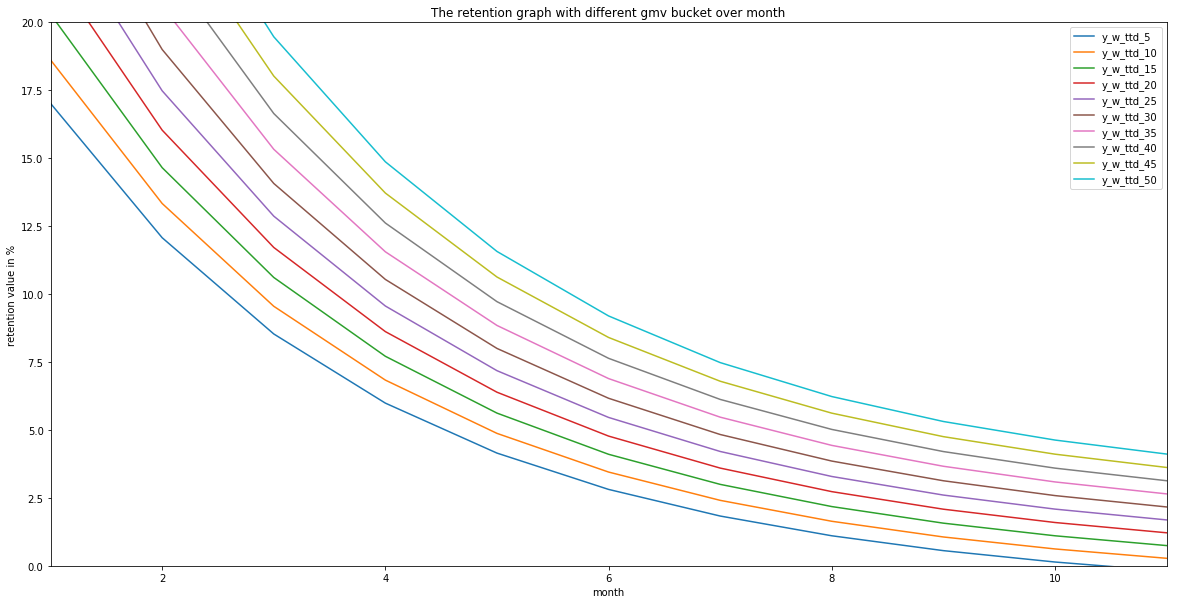

In [476]:
ttd = list(np.arange(5, 55, 5))
y_name = ['y_w_ttd_' + str(i) for i in ttd]

df_simulated = pd.DataFrame(columns=y_name)

# x is month from 1-12
df_simulated['x'] = list(np.arange(1, 12, 1))

for i,c in zip(ttd,y_name):

    simulated_month = df_simulated['x']
    simulated_ttd = [i]*len(simulated_month)
#     inside_intercept = [1]*len(simulated_month)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]= func_exp_d1(X_df, *popt_d1)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('month')
plt.ylabel('retention value in %')
plt.ylim(-0,20)
plt.xlim(1,)
plt.title('The retention graph with different gmv bucket over month')

Text(0.5,1,'The retention graph with different gmv bucket over ttd')

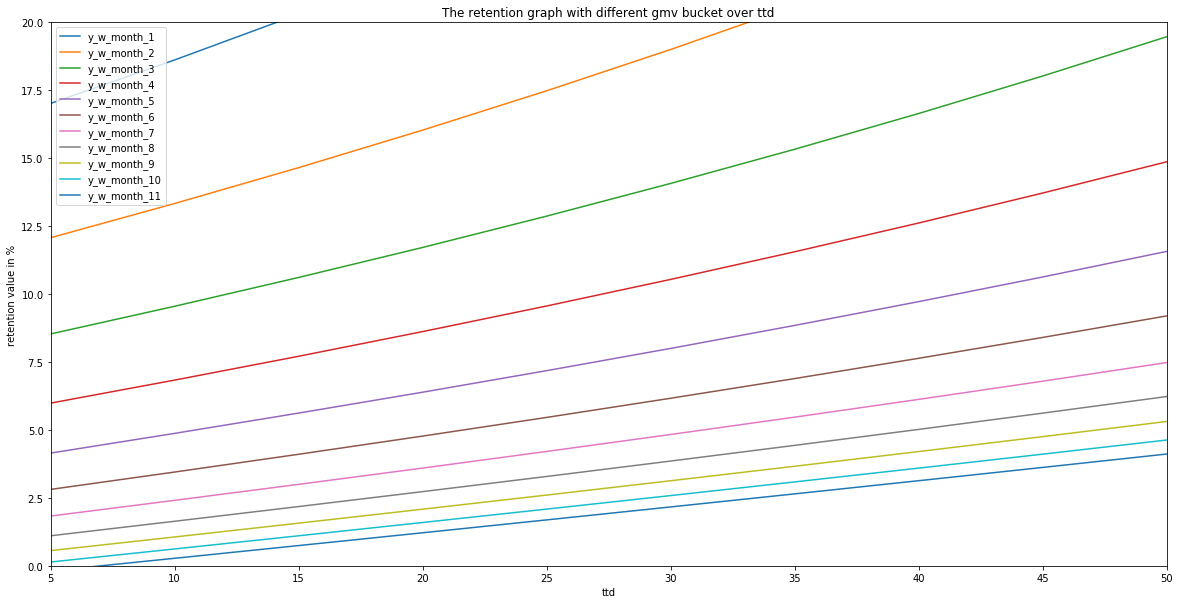

In [477]:
month =  list(np.arange(1, 12, 1))
y_name = ['y_w_month_' + str(i) for i in month]

df_simulated = pd.DataFrame(columns=y_name)

# x is ttd
df_simulated['x'] = list(np.arange(5, 55, 5))

# X['sqrt_rentention_month_bucket'] = np.sqrt(X['rentention_month_bucket'])

for i,c in zip(month,y_name):

    simulated_ttd = df_simulated['x']
    simulated_month = [i]*len(simulated_ttd)
    inside_intercept = [1]*len(simulated_ttd)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]=func_exp_d1(X_df, *popt_d1)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('ttd')
plt.ylabel('retention value in %')
plt.ylim(0,20)
plt.xlim(5,)
plt.title('The retention graph with different gmv bucket over ttd')

In [482]:
def func_exp_d2_interaction_only(X, a, b, c, d, e, f, g):
    ttd = X['mixed_ttd_mean_bucket_med']
    month = X['retention_month_bucket']
    inter = ttd * month
#     return b* np.exp(-c * ttd - d*month - e*ttd*month) + f*ttd + g*month + h*ttd*month
    return b* np.exp(-c * ttd - d*month - e*ttd*inter) + f*ttd + g*month + a*inter

In [483]:
popt_d2_interaction_only, pcov_d2_interaction_only = curve_fit(func_exp_d2_interaction_only, X2_train, y2_train)
popt_d2_interaction_only,pcov_d2_interaction_only

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


(array([-2.92034581e-02,  1.11229687e+01, -4.86696120e-02,  2.59234669e-01,
         7.40546855e-04,  3.83315121e-01, -4.72444766e-02]),
 array([[ 5.33982428e-06,  1.11967105e-04,  5.12853326e-07,
         -1.16069128e-05, -5.25387458e-08, -3.44867017e-05,
         -3.87499678e-05],
        [ 1.11967105e-04,  3.47679858e-01,  1.65592076e-03,
          7.64130217e-03, -2.87321663e-05, -2.99627329e-03,
          3.83436530e-03],
        [ 5.12853326e-07,  1.65592076e-03,  8.65908112e-06,
          3.49508838e-05, -1.53051631e-07, -1.38936038e-05,
          1.60213576e-05],
        [-1.16069128e-05,  7.64130217e-03,  3.49508838e-05,
          2.62232026e-04, -6.30226751e-07,  1.28852244e-05,
          2.28134691e-04],
        [-5.25387458e-08, -2.87321663e-05, -1.53051631e-07,
         -6.30226751e-07,  3.92160070e-09,  6.70828758e-07,
         -2.18648419e-07],
        [-3.44867017e-05, -2.99627329e-03, -1.38936038e-05,
          1.28852244e-05,  6.70828758e-07,  2.93598040e-04,
        

In [484]:
y2_test_pred = func_exp_d2_interaction_only(X2_test, *popt_d2_interaction_only)
model_mse = mean_squared_error(y2_test, y2_test_pred)
model_rmse =  math.sqrt(model_mse)
model_r2 = r2_score(y2_test, y2_test_pred)
adjusted_r2 = 1 - (1-model_r2)*(len(y2_test)-1)/(len(y2_test)-PolynomialFeatures(2, include_bias=False,interaction_only=True).fit_transform(X2_test).shape[1]-1)
model_rmse,model_r2,adjusted_r2

(3.7812796491520007, 0.7350955541214528, 0.7348302074310903)

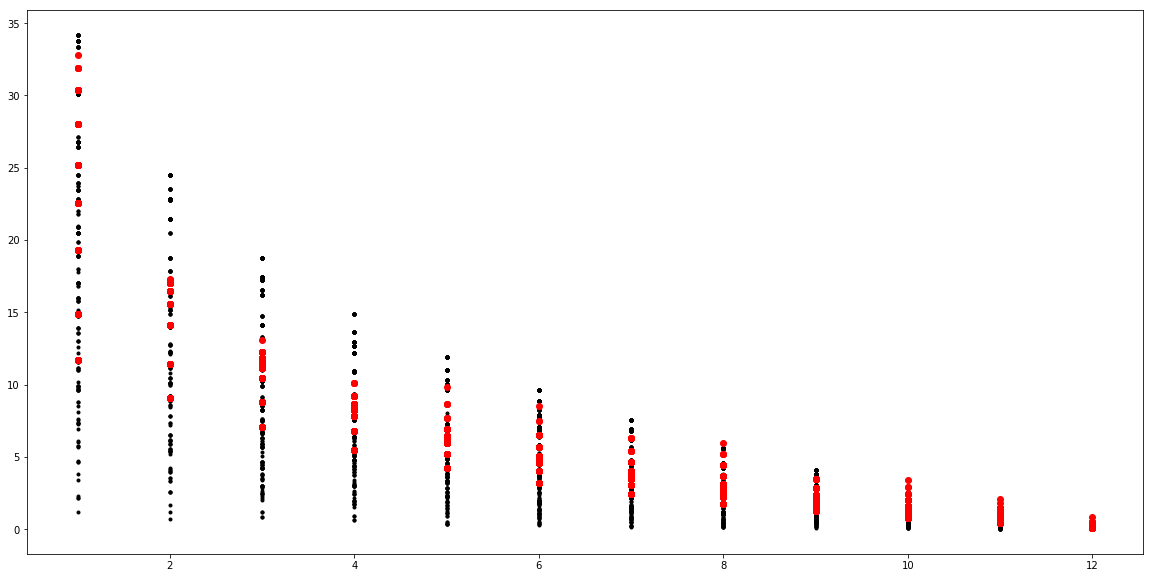

In [485]:
plt.figure(figsize=(20,10))
plt.plot(X2_test['retention_month_bucket'], y2_test, 'k.', label="Original Noised Data")
plt.plot(X2_test['retention_month_bucket'], y2_test_pred, 'ro', label="Fitted Curve")

In [486]:
# plt.figure(figsize=(20,10))
# plt.plot(X2_test['mixed_ttd_mean_bucket_med'], y2_test, 'k.', label="Original Noised Data")
# plt.plot(X2_test['mixed_ttd_mean_bucket_med'], y2_test_pred, 'ro', label="Fitted Curve")

Text(0.5,1,'The retention graph with different gmv bucket over month')

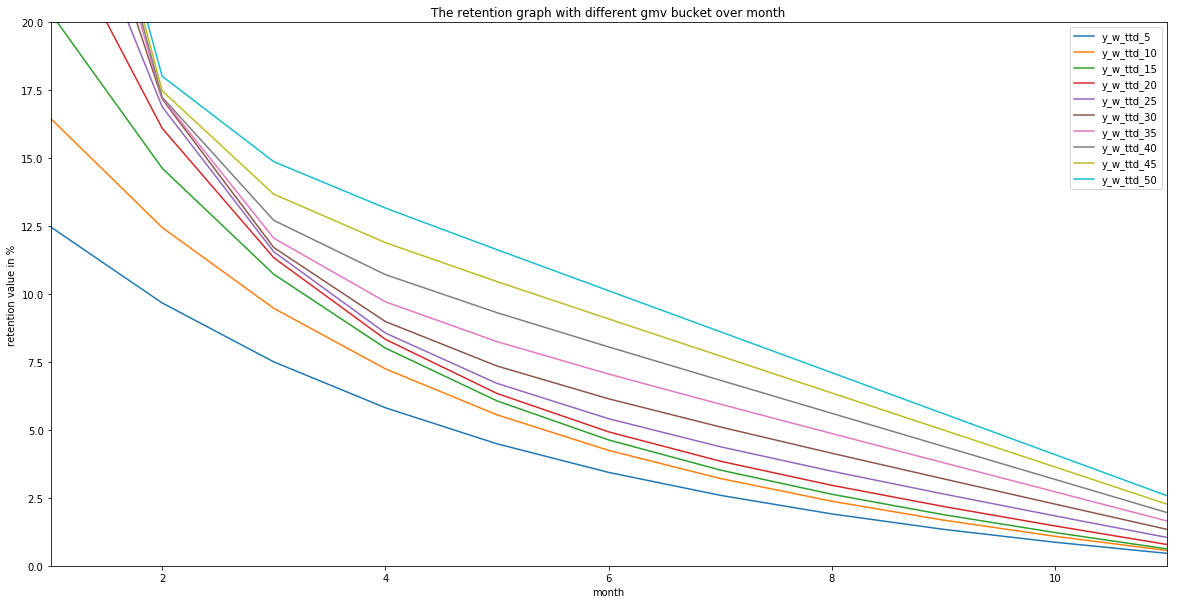

In [487]:
ttd = list(np.arange(5, 55, 5))
y_name = ['y_w_ttd_' + str(i) for i in ttd]

df_simulated = pd.DataFrame(columns=y_name)

# x is month from 1-12
df_simulated['x'] = list(np.arange(1, 12, 1))

for i,c in zip(ttd,y_name):

    simulated_month = df_simulated['x']
    simulated_ttd = [i]*len(simulated_month)
#     inside_intercept = [1]*len(simulated_month)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]= func_exp_d2_interaction_only(X_df, *popt_d2_interaction_only)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('month')
plt.ylabel('retention value in %')
plt.ylim(0,20)
plt.xlim(1,)
plt.title('The retention graph with different gmv bucket over month')

Text(0.5,1,'The retention graph with different gmv bucket over ttd')

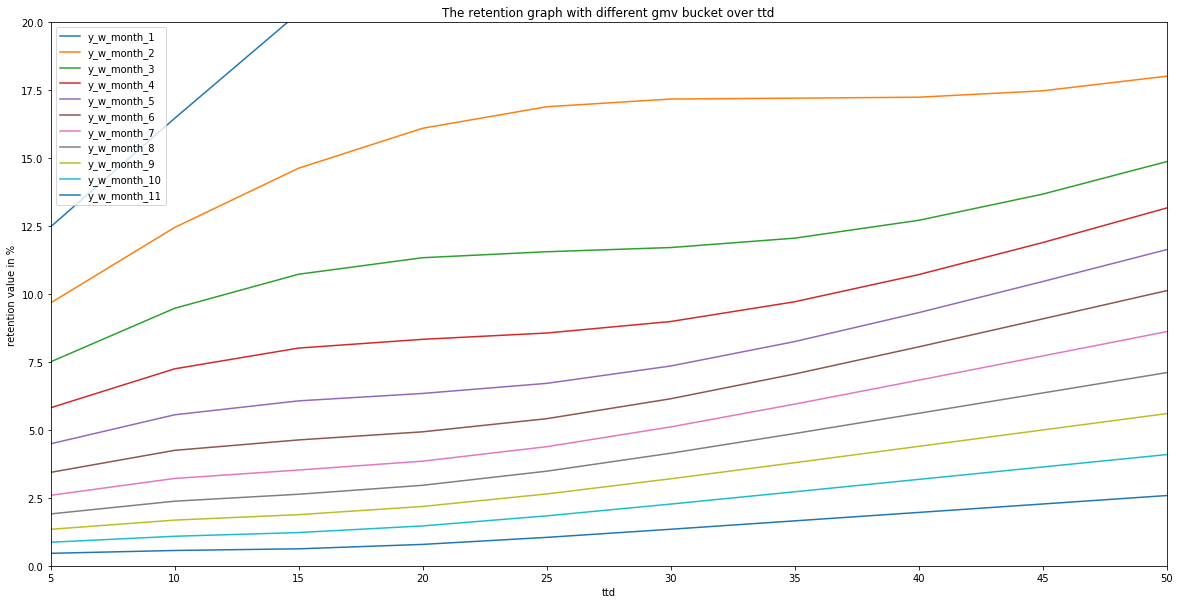

In [488]:
month =  list(np.arange(1, 12, 1))
y_name = ['y_w_month_' + str(i) for i in month]

df_simulated = pd.DataFrame(columns=y_name)

# x is ttd
df_simulated['x'] = list(np.arange(5, 55, 5))

# X['sqrt_rentention_month_bucket'] = np.sqrt(X['rentention_month_bucket'])

for i,c in zip(month,y_name):

    simulated_ttd = df_simulated['x']
    simulated_month = [i]*len(simulated_ttd)
    inside_intercept = [1]*len(simulated_ttd)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]=func_exp_d2_interaction_only(X_df, *popt_d2_interaction_only)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('ttd')
plt.ylabel('retention value in %')
plt.ylim(0,20)
plt.xlim(5,)
plt.title('The retention graph with different gmv bucket over ttd')

In [744]:
def func_exp_d2(X, a,b, c, d, e,f,g,h,i,j,k):
    ttd = X['mixed_ttd_mean_bucket_med']
    month = X['retention_month_bucket']
    inter = ttd * month
    ttd2 = ttd**2
    month2=month**2
    x1 = b*ttd
    x2 = c*month
    x3 = d*inter
    x4 = e*ttd2
    x5 = f*month2
    x6 = g*ttd
    x7 = h*month
    x8 = i*ttd2
    x9 = j*month2
    return a* np.exp(-x1 -x2 -x4 -x5) + x6 

In [745]:
popt_d2, _ = curve_fit(func_exp_d2, X2_train, y2_train)
popt_d2
y2_test_pred = func_exp_d2(X2_test, *popt_d2)
model_mse = mean_squared_error(y2_test, y2_test_pred)
model_rmse =  math.sqrt(model_mse)
model_r2 = r2_score(y2_test, y2_test_pred)
adjusted_r2 = 1 - (1-model_r2)*(len(y2_test)-1)/(len(y2_test)-PolynomialFeatures(2, include_bias=False,interaction_only=False).fit_transform(X2_test).shape[1]-1)
model_rmse,model_r2,adjusted_r2

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(3.183482655580948, 0.8122341409380083, 0.8119204659312225)

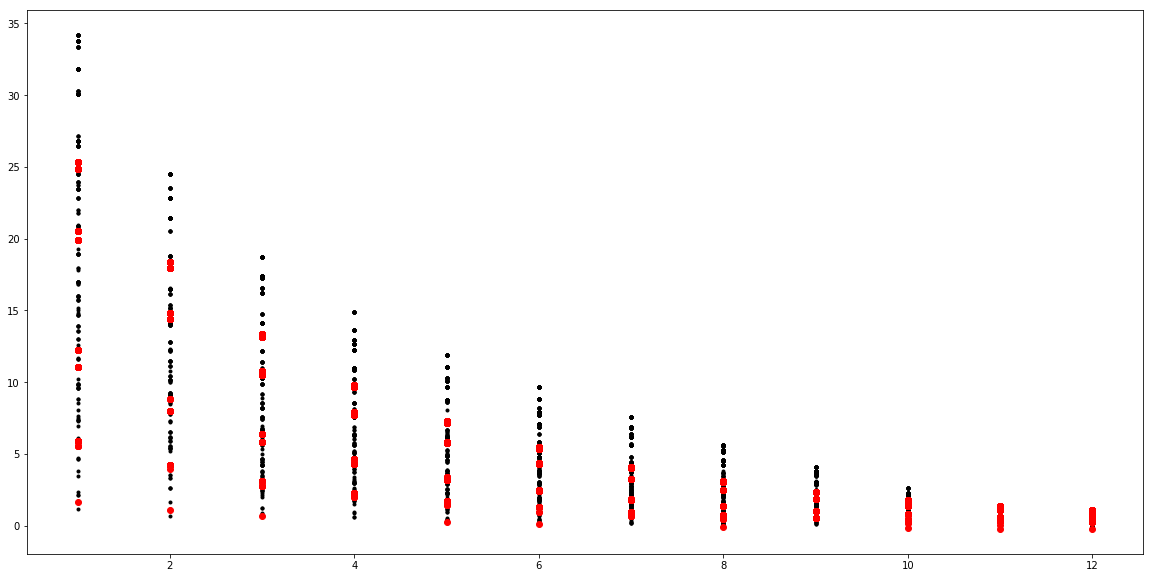

In [746]:
plt.figure(figsize=(20,10))
plt.plot(X2_test['retention_month_bucket'], y2_test, 'k.', label="Original Noised Data")
plt.plot(X2_test['retention_month_bucket'], y2_test_pred, 'ro', label="Fitted Curve")

Text(0.5,1,'The retention graph with different gmv bucket over month')

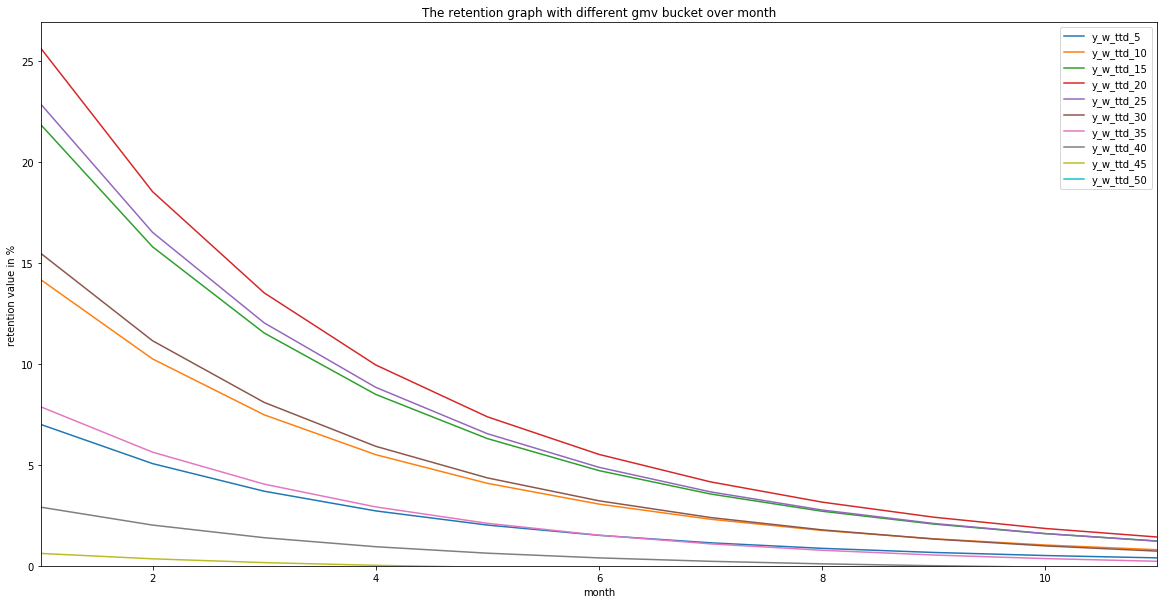

In [747]:
ttd = list(np.arange(5, 55, 5))
y_name = ['y_w_ttd_' + str(i) for i in ttd]

df_simulated = pd.DataFrame(columns=y_name)

# x is month from 1-12
df_simulated['x'] = list(np.arange(1, 12, 1))

for i,c in zip(ttd,y_name):

    simulated_month = df_simulated['x']
    simulated_ttd = [i]*len(simulated_month)
#     inside_intercept = [1]*len(simulated_month)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]= func_exp_d2(X_df, *popt_d2)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('month')
plt.ylabel('retention value in %')
plt.ylim(0,)
plt.xlim(1,)
plt.title('The retention graph with different ttd bucket over month')

Text(0.5,1,'The retention graph with different gmv bucket over ttd')

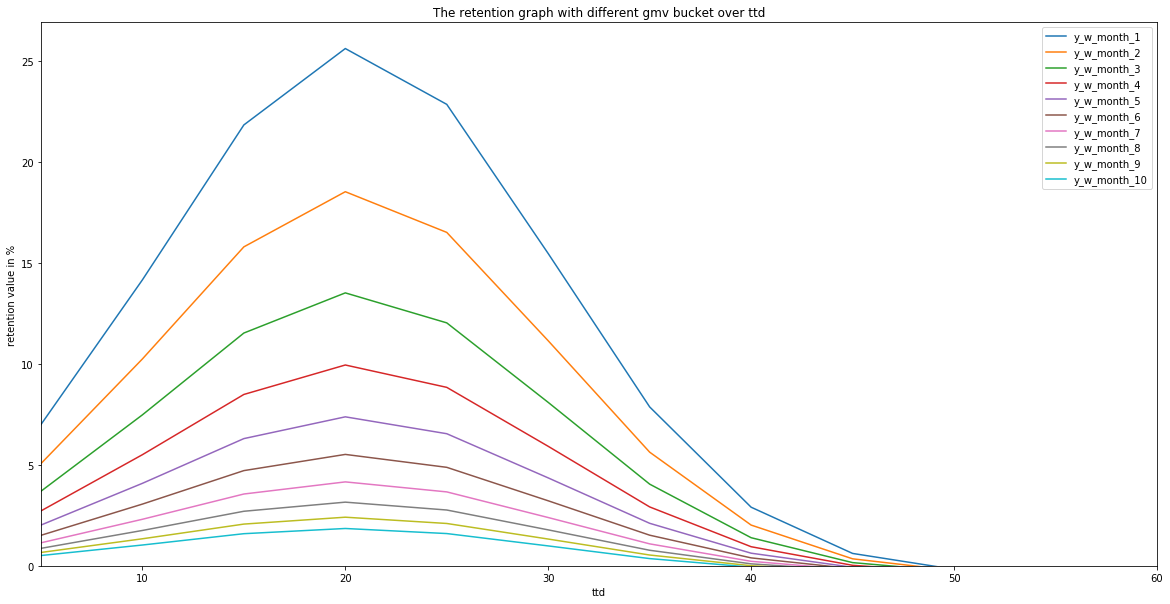

In [748]:
month =  list(np.arange(1, 11, 1))
y_name = ['y_w_month_' + str(i) for i in month]

df_simulated = pd.DataFrame(columns=y_name)

# x is ttd
df_simulated['x'] = list(np.arange(5, 65, 5))

# X['sqrt_rentention_month_bucket'] = np.sqrt(X['rentention_month_bucket'])

for i,c in zip(month,y_name):

    simulated_ttd = df_simulated['x']
    simulated_month = [i]*len(simulated_ttd)
    inside_intercept = [1]*len(simulated_ttd)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]=func_exp_d2(X_df, *popt_d2)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('ttd')
plt.ylabel('retention value in %')
plt.ylim(-0,)
plt.xlim(5,)
plt.title('The retention graph with different gmv bucket over ttd')

## adding more features

### adding TTD expectation delay 

In [1138]:
df.head()

,user_first_txn_refund_category,logistics_o_overall_refund_bucket,llr_bucket,first_txn_month,avg_gmv_bucket_med,mixed_ttd_mean_bucket_med,carrier_ttd_mean_bucket_med,late_mixed_delivery_perc_med,user_cnt_m0,user_cnt_m1,...,trans_cnt_m3,trans_cnt_m4,trans_cnt_m5,trans_cnt_m6,trans_cnt_m7,trans_cnt_m8,trans_cnt_m9,trans_cnt_m10,trans_cnt_m11,trans_cnt_m12
0,None,40,20,2019-12,52.4,21.9,21.9,65.4,1,0,...,0,0,0,0,0,0,0,0,0,0
1,other refund,0,0,2019-11,13.0,37.0,21.9,16.7,1,0,...,0,0,0,0,0,0,0,0,0,0
2,no refund,60,20,2019-09,13.0,18.0,13.6,5.6,16,11,...,33,0,0,0,0,0,0,0,0,0
3,no refund,0,0,2019-04,7.0,4.0,13.6,5.6,1,1,...,0,0,0,0,0,0,0,0,0,0
4,no refund,0,0,2019-08,1.1,21.9,21.9,5.6,66,51,...,927,100,0,0,0,0,0,0,0,0


In [1139]:
feature0 = ['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med']
df_trainning3 = prepare_base_date(df,feature0)

df_trainning3.loc[df_trainning3.retention_value<0.001,'retention_value'] = 0.0001
df_trainning3.head(),df_trainning3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 6 columns):
late_mixed_delivery_perc_med    432 non-null float64
mixed_ttd_mean_bucket_med       432 non-null float64
user_cnt_m0                     432 non-null int64
retention_month_bucket          432 non-null int64
user_cnt                        432 non-null int64
retention_value                 432 non-null float64
dtypes: float64(3), int64(3)
memory usage: 20.3 KB


(   late_mixed_delivery_perc_med  mixed_ttd_mean_bucket_med  user_cnt_m0  \
 0                           5.6                        4.0          690   
 1                           5.6                        8.0        18518   
 2                           5.6                       13.6        96465   
 3                           5.6                       18.0       297459   
 4                           5.6                       21.9       155060   
 
    retention_month_bucket  user_cnt  retention_value  
 0                       1       295           42.754  
 1                       1      8932           48.234  
 2                       1     53127           55.074  
 3                       1    168285           56.574  
 4                       1     77447           49.946  , None)

In [1140]:
df_trainning3[df_trainning3.retention_value==0]

,late_mixed_delivery_perc_med,mixed_ttd_mean_bucket_med,user_cnt_m0,retention_month_bucket,user_cnt,retention_value


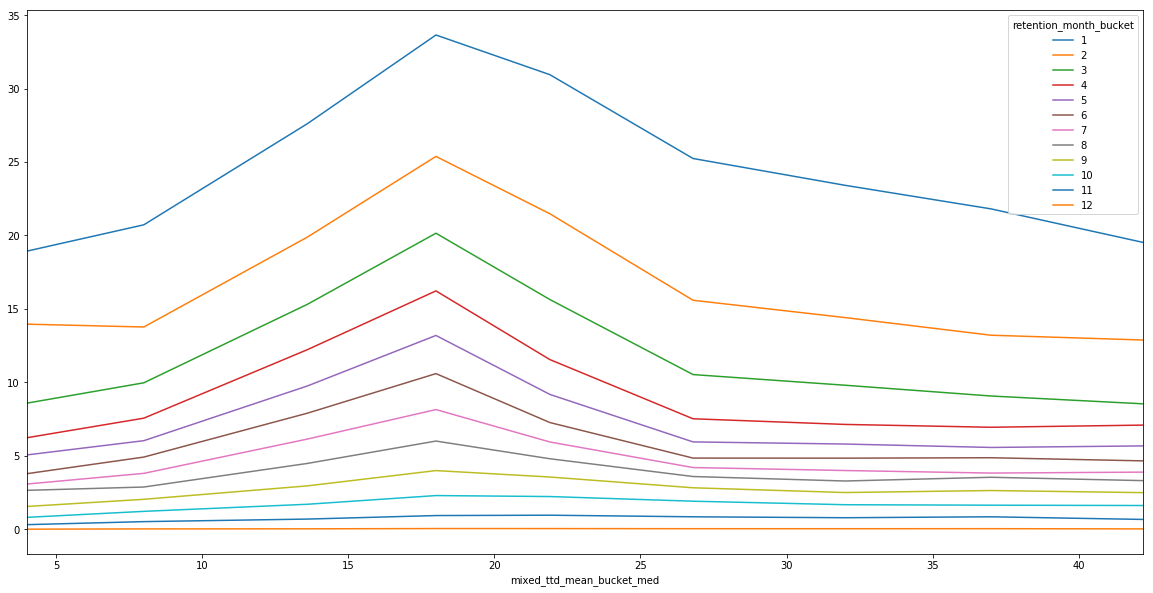

In [1141]:
df_trainning3.pivot_table(columns='retention_month_bucket', values='retention_value', index='mixed_ttd_mean_bucket_med').plot(figsize=(20, 10))

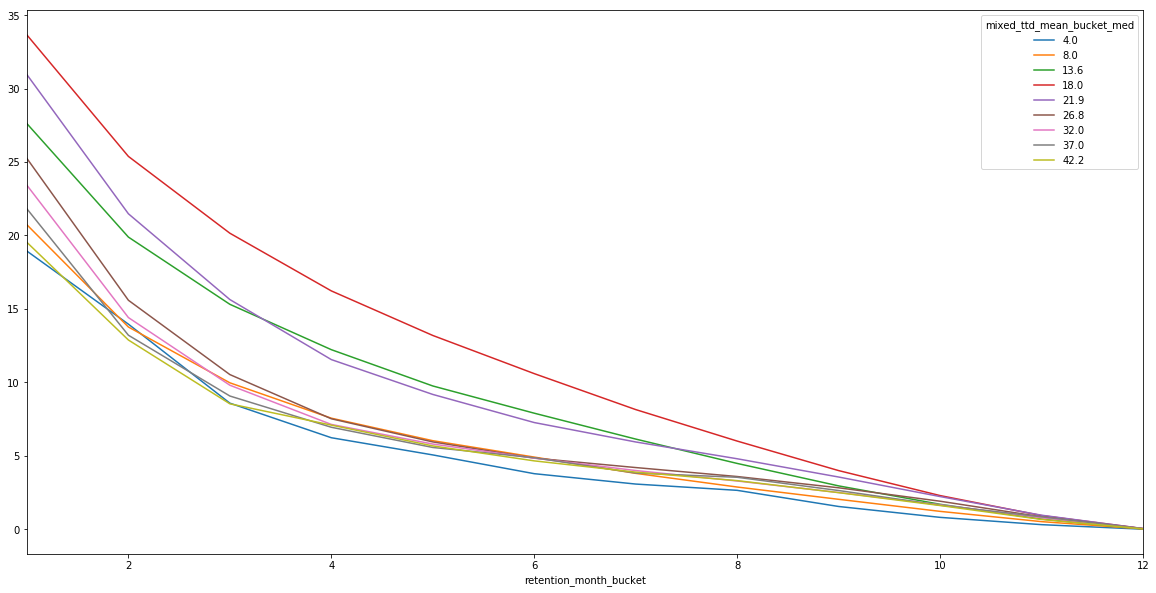

In [1142]:
df_trainning3.pivot_table(columns='mixed_ttd_mean_bucket_med', values='retention_value', index='retention_month_bucket').plot(figsize=(20, 10))

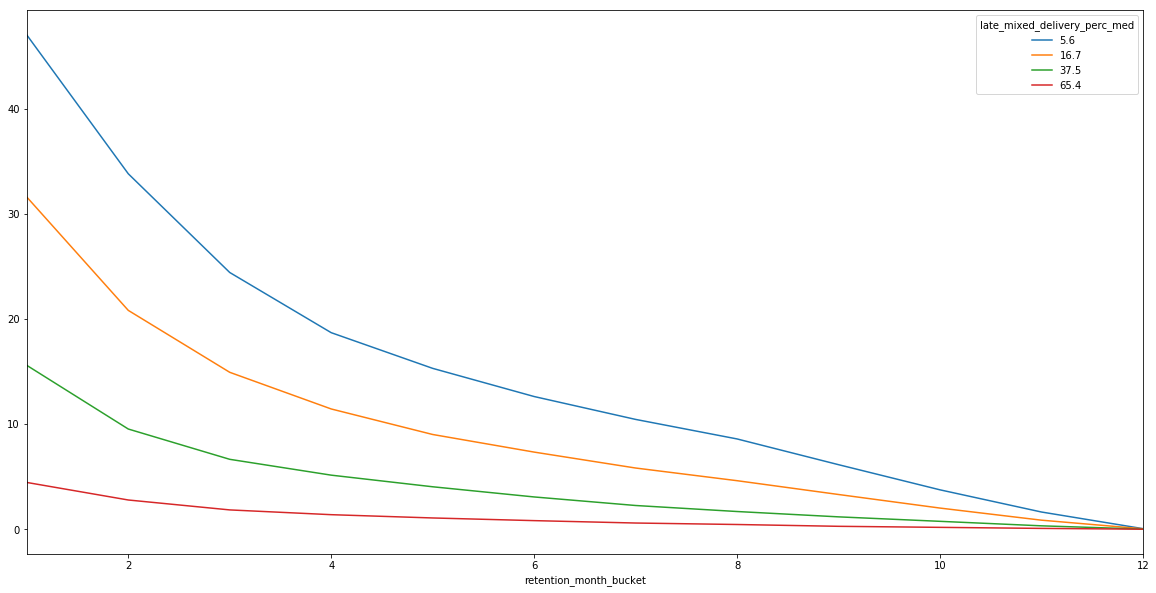

In [1143]:
df_trainning3.pivot_table(columns='late_mixed_delivery_perc_med', values='retention_value', index='retention_month_bucket').plot(figsize=(20, 10))

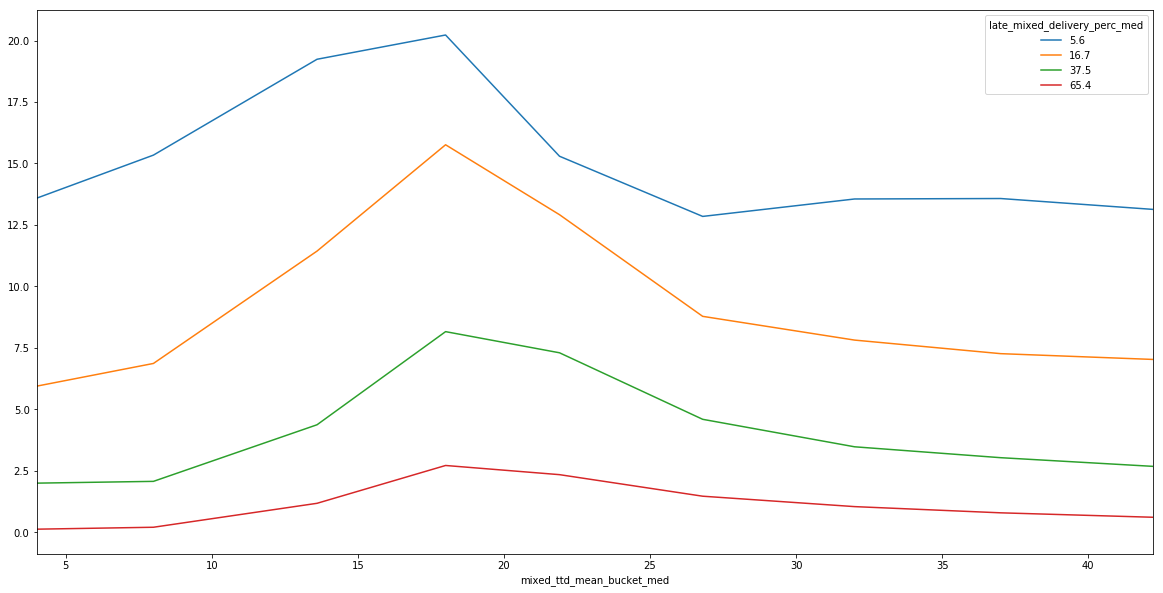

In [1144]:
df_trainning3.pivot_table(columns='late_mixed_delivery_perc_med', values='retention_value', index='mixed_ttd_mean_bucket_med').plot(figsize=(20, 10))

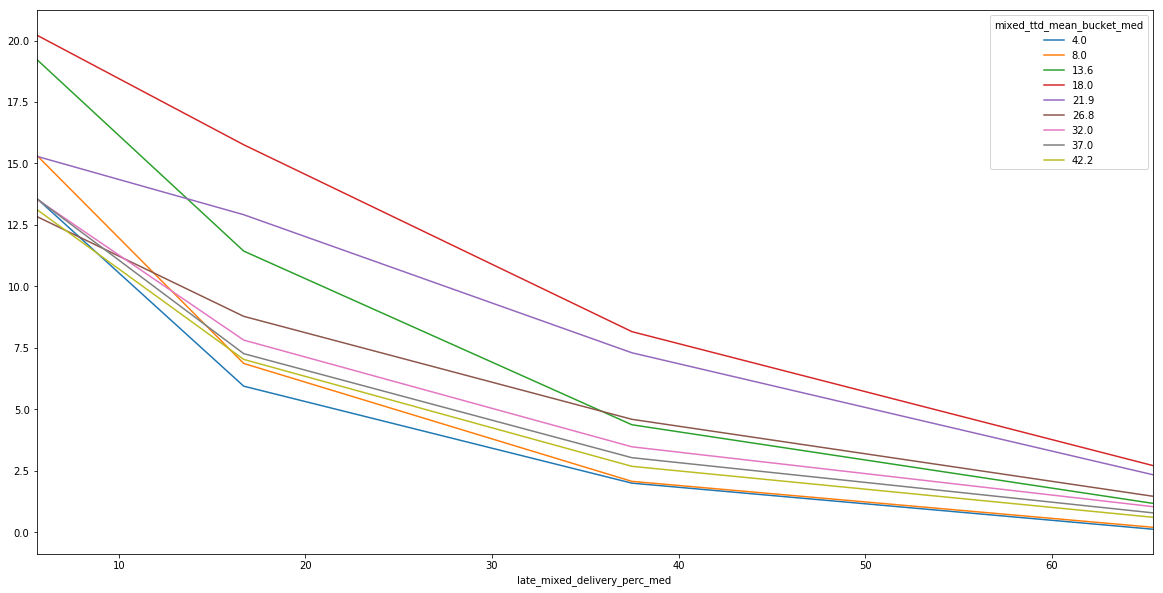

In [1145]:
df_trainning3.pivot_table(columns='mixed_ttd_mean_bucket_med', values='retention_value', index='late_mixed_delivery_perc_med').plot(figsize=(20, 10))

### from above observation, the 'late_mixed_delivery_perc_med'(not 'late_mixed_ttd_diff_bucket_med') can be choose as 2nd features

In [1146]:
df_trainning3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 6 columns):
late_mixed_delivery_perc_med    432 non-null float64
mixed_ttd_mean_bucket_med       432 non-null float64
user_cnt_m0                     432 non-null int64
retention_month_bucket          432 non-null int64
user_cnt                        432 non-null int64
retention_value                 432 non-null float64
dtypes: float64(3), int64(3)
memory usage: 20.3 KB


In [1403]:
df0 = df_trainning3
weight_name = 'user_cnt_m0'
full_list=['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med','retention_month_bucket','retention_value']
df_weight = simulated_sample_data_w_weight(df=df0,full_list=full_list,weigt_name=weight_name)
df_weight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9996 entries, 0 to 9995
Data columns (total 4 columns):
late_mixed_delivery_perc_med    9996 non-null float64
mixed_ttd_mean_bucket_med       9996 non-null float64
retention_month_bucket          9996 non-null float64
retention_value                 9996 non-null float64
dtypes: float64(4)
memory usage: 312.5 KB


In [1404]:
X2_train, y2_train, X2_test, y2_test = split_train_test_w_weight_2(df_weight,state=9,feature_name=['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med','retention_month_bucket'],w=None,inside_intercept=False)
X2_train.shape,X2_test.shape,y2_train.shape,y2_test.shape

((6997, 3), (2999, 3), (6997,), (2999,))

In [1472]:
def func_exp_d2(X, a,b, c, d, e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u):
    ttd = X['mixed_ttd_mean_bucket_med']
    month = X['retention_month_bucket']
    late = X['late_mixed_delivery_perc_med']
    
    ttd2 = ttd**2
    month2=month**2
    late2 = late**2
    
    x1 = b*ttd #0.14
    x4 = e*ttd2 #-0.0045
    x6 = g*ttd 
    x8 = i*ttd2 
    
    x2 = c*month #0.23
    x5 = f*month2 #-0.056
    x7 = h*month
    x9 = j*month2
    
    x10 = k*late #-0.043
    x11 = l*late2 #-0.000323
    x12 = m*late 
    x13 = n*late2
    
    x3 = d*ttd * month
    x14 = o*ttd * late
    x15 = p*month*late
    x16 = q*ttd*month*late
    x17 = r*ttd * month
    x18 = s*ttd * late
    x19 = t*month*late
    x20 = u*ttd*month*late
    return a* np.exp(1) +(x6+x8) +(x7+x9) + (x12+x13) +(x17+x18+x19)
#     return 10*a* np.exp(-x1 -x2 -x4 -x5 -x10 -x11 -(x17+x18+x19+x20))

In [1473]:
# p0 = [1,0.14,0.23,1,0.0045,0.056,1,1,1,1,0.043,0.000323,1,1,1,1,1,1,1,1,0.5]

popt_d2, _ = curve_fit(func_exp_d2, X2_train, y2_train)
popt_d2
parameter=list('abcdefghijklmnopqrstuz')
pd.DataFrame(zip(parameter,popt_d2))

,0,1
0,a,20.423809
1,b,1.000000
2,c,1.000000
3,d,1.000000
4,e,1.000000
5,f,1.000000
6,g,0.505829
7,h,-8.329829
8,i,-0.020356
9,j,0.284615


In [1454]:
y2_test_pred = func_exp_d2(X2_test, *popt_d2)
model_mse = mean_squared_error(y2_test, y2_test_pred)
model_rmse =  math.sqrt(model_mse)
model_r2 = r2_score(y2_test, y2_test_pred)
adjusted_r2 = 1 - (1-model_r2)*(len(y2_test)-1)/(len(y2_test)-PolynomialFeatures(2, include_bias=False,interaction_only=False).fit_transform(X2_test).shape[1]-1)
print(model_rmse,model_r2,adjusted_r2)

3.520483077941549 0.9213328821186016 0.9210960122420768


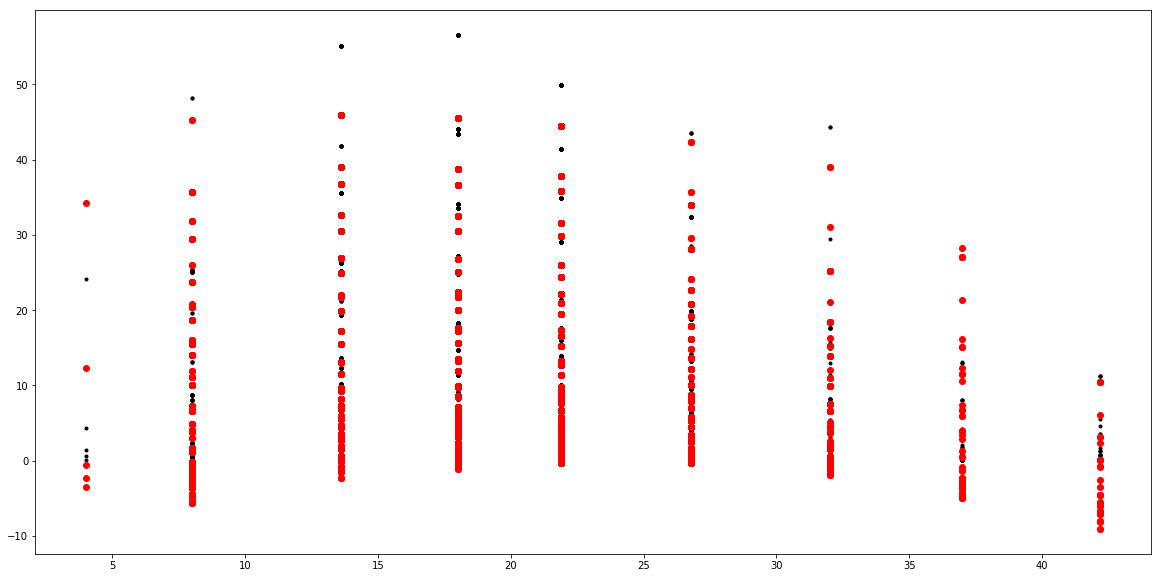

In [1455]:
plt.figure(figsize=(20,10))
plt.plot(X2_test['mixed_ttd_mean_bucket_med'], y2_test, 'k.', label="Original Noised Data")
plt.plot(X2_test['mixed_ttd_mean_bucket_med'], y2_test_pred, 'ro', label="Fitted Curve")

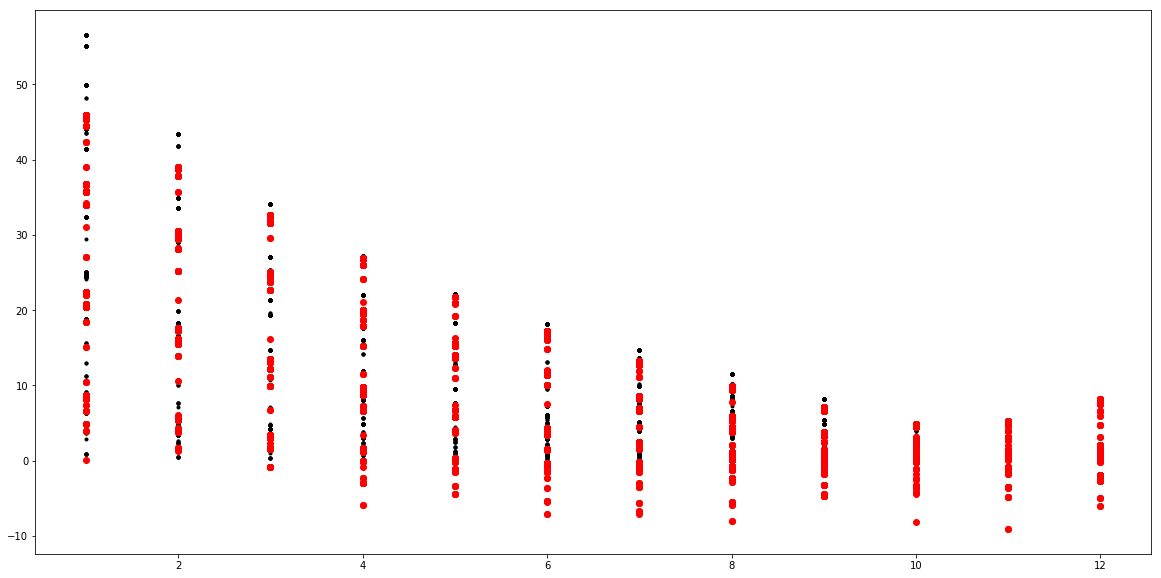

In [1456]:
plt.figure(figsize=(20,10))
plt.plot(X2_test['retention_month_bucket'], y2_test, 'k.', label="Original Noised Data")
plt.plot(X2_test['retention_month_bucket'], y2_test_pred, 'ro', label="Fitted Curve")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


Text(0.5,1,'The retention graph with different gmv bucket over month')

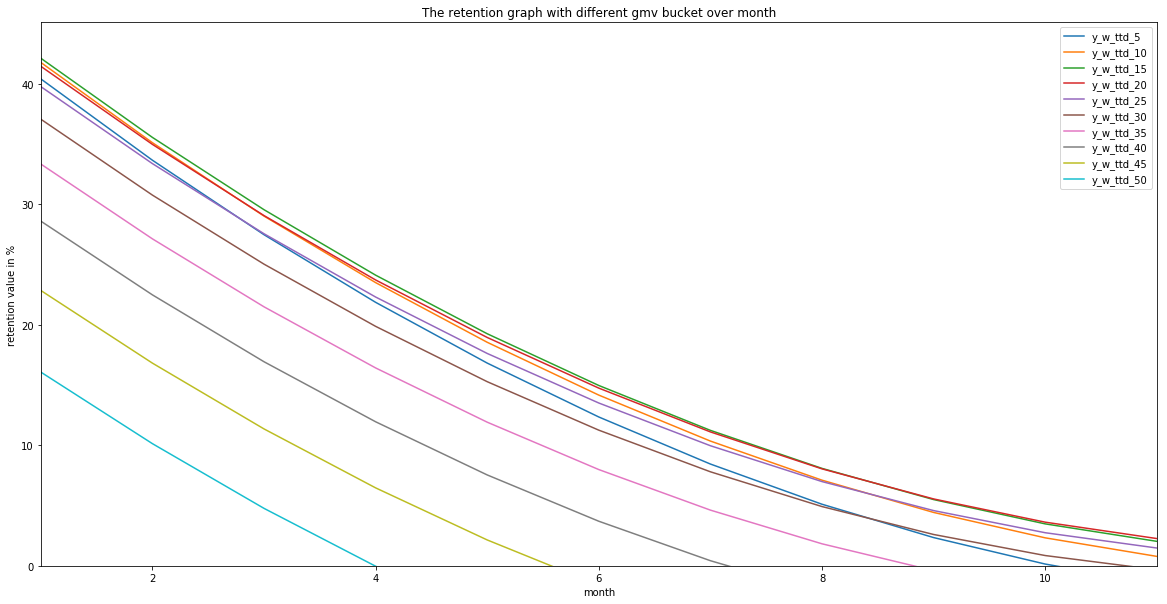

In [1457]:
ttd = list(np.arange(5, 55, 5))
y_name = ['y_w_ttd_' + str(i) for i in ttd]

df_simulated = pd.DataFrame(columns=y_name)

# x is month from 1-12
df_simulated['x'] = list(np.arange(1, 12, 1))
late_delivery_perc = 10

for i,c in zip(ttd,y_name):

    simulated_month = df_simulated['x']
    simulated_ttd = [i]*len(simulated_month)
    simulated_late_delivery_perc = [late_delivery_perc] *len(simulated_month)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_late_delivery_perc,simulated_ttd,simulated_month)),columns=['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]= func_exp_d2(X_df, *popt_d2)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('month')
plt.ylabel('retention value in %')
plt.ylim(0,)
plt.xlim(1,)
plt.title('The retention graph with different gmv bucket over month')

Text(0.5,1,'The retention graph with different gmv bucket over month')

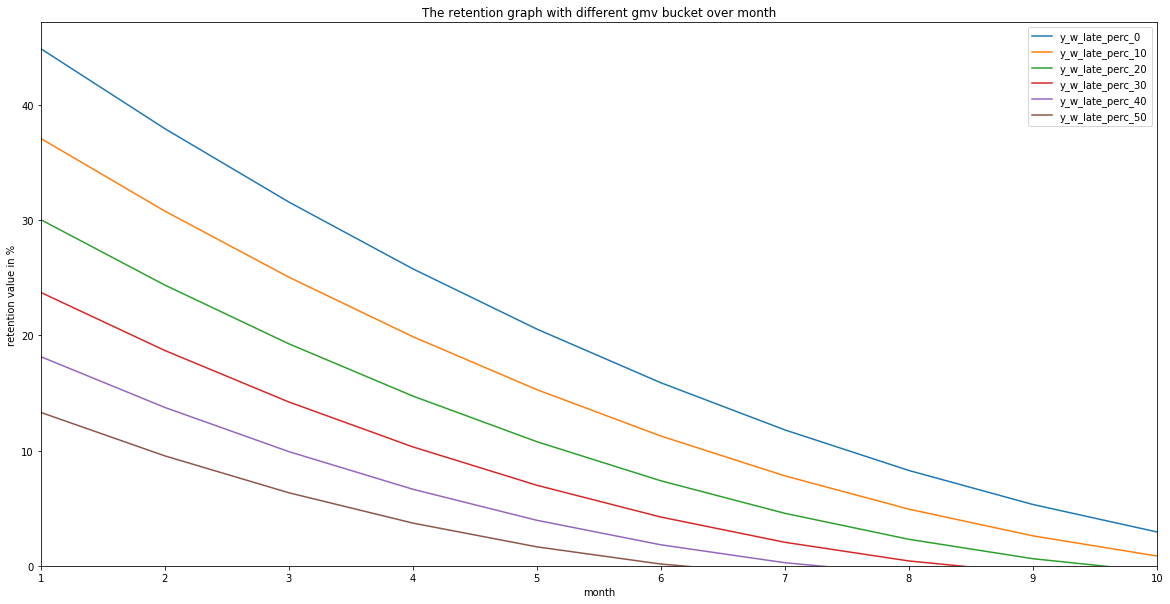

In [1458]:
late_perc = list(np.arange(0, 60, 10))
y_name = ['y_w_late_perc_' + str(i) for i in late_perc]

df_simulated = pd.DataFrame(columns=y_name)

# x is month from 1-12
df_simulated['x'] = list(np.arange(1, 11, 1))
ttd = 30

for i,c in zip(late_perc,y_name):

    simulated_month = df_simulated['x']
    simulated_ttd = [ttd]*len(simulated_month)
    simulated_late_delivery_perc = [i] *len(simulated_month)

#     X_df = pd.DataFrame(list(zip(simulated_ttd,simulated_month,inside_intercept)),columns=['mixed_ttd_mean_bucket_med','retention_month_bucket','inside_intercept'])
    X_df = pd.DataFrame(list(zip(simulated_late_delivery_perc,simulated_ttd,simulated_month)),columns=['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]= func_exp_d2(X_df, *popt_d2)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('month')
plt.ylabel('retention value in %')
plt.ylim(0,)
plt.xlim(1,)
plt.title('The retention graph with different gmv bucket over month')

Text(0.5,1,'The retention graph with different gmv bucket over ttd')

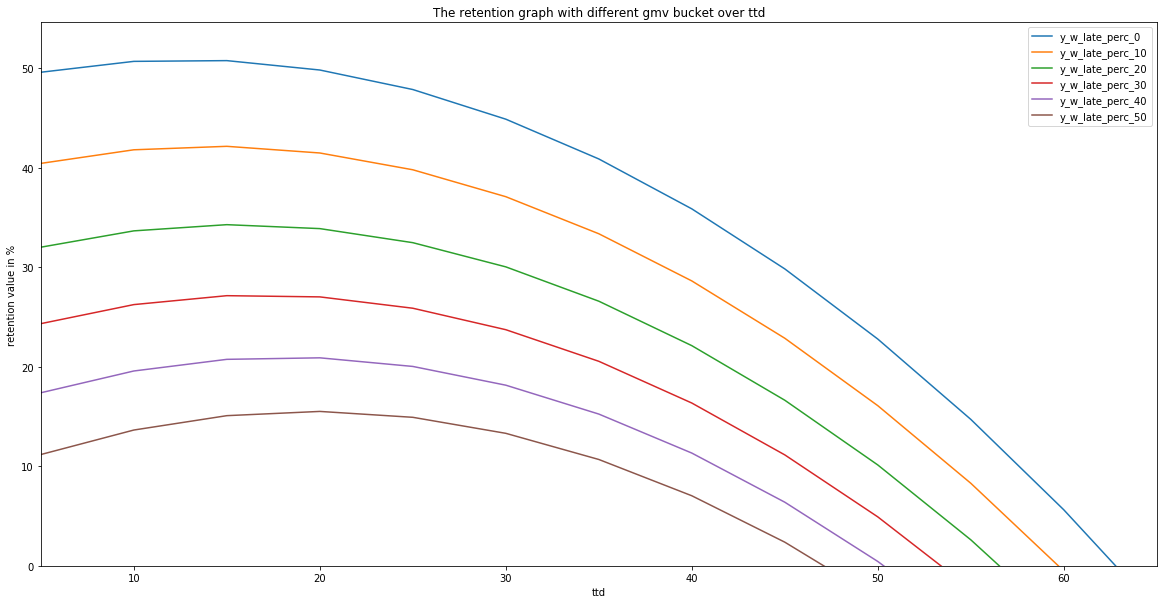

In [1459]:
late_perc = list(np.arange(0, 60, 10))
y_name = ['y_w_late_perc_' + str(i) for i in late_perc]

df_simulated = pd.DataFrame(columns=y_name)

# x is ttd
df_simulated['x'] = list(np.arange(5, 70, 5))
month = 1

for i,c in zip(late_perc,y_name):

    simulated_ttd = df_simulated['x']
    simulated_month = [month]*len(simulated_ttd)
    simulated_late_delivery_perc = [i] *len(simulated_ttd)

    X_df = pd.DataFrame(list(zip(simulated_late_delivery_perc,simulated_ttd,simulated_month)),columns=['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]=func_exp_d2(X_df, *popt_d2)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('ttd')
plt.ylabel('retention value in %')
plt.ylim(-0,)
plt.xlim(5,)
plt.title('The retention graph with different gmv bucket over ttd')

Text(0.5,1,'The retention graph with different retention month bucket over ttd')

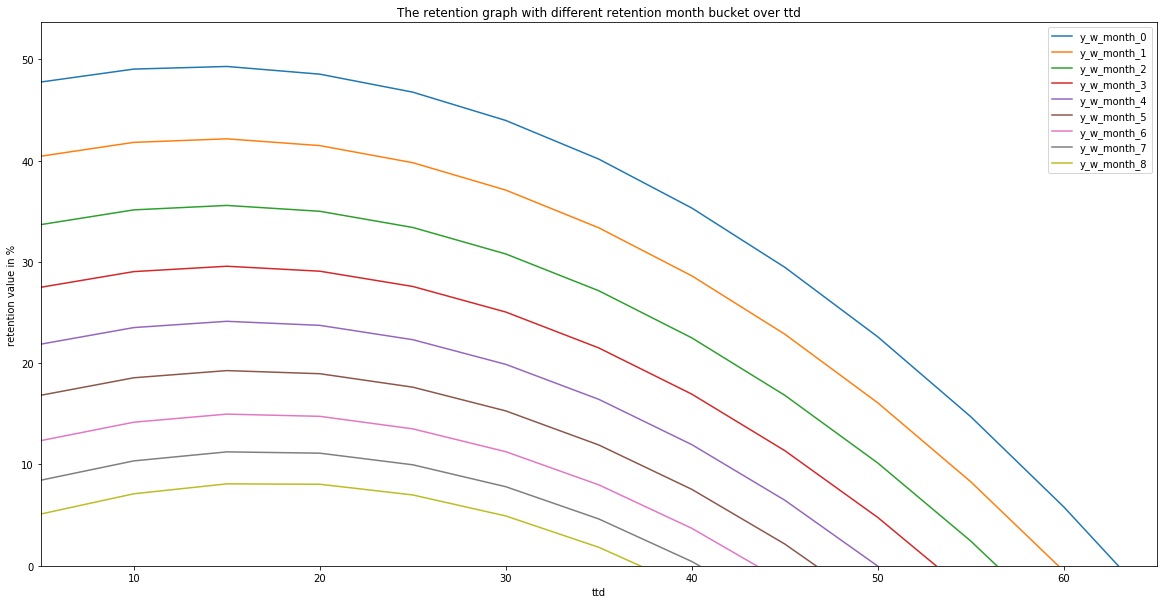

In [1475]:
# set up the groups
group = list(np.arange(0, 9, 1))
y_name = ['y_w_month_' + str(i) for i in group]

df_simulated = pd.DataFrame(columns=y_name)

# x is ttd
df_simulated['x'] = list(np.arange(5, 70, 5))
late_perc = 10

for i,c in zip(group,y_name):

    simulated_ttd = df_simulated['x']
    simulated_month = [i]*len(simulated_ttd)
    simulated_late_delivery_perc = [late_perc] *len(simulated_ttd)

    X_df = pd.DataFrame(list(zip(simulated_late_delivery_perc,simulated_ttd,simulated_month)),columns=['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]=func_exp_d2(X_df, *popt_d2)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('ttd')
plt.ylabel('retention value in %')
plt.ylim(-0,)
plt.xlim(5,)
plt.title('The retention graph with different retention month bucket over ttd')

Text(0.5,1,'The retention graph with different retention month bucket over late perc')

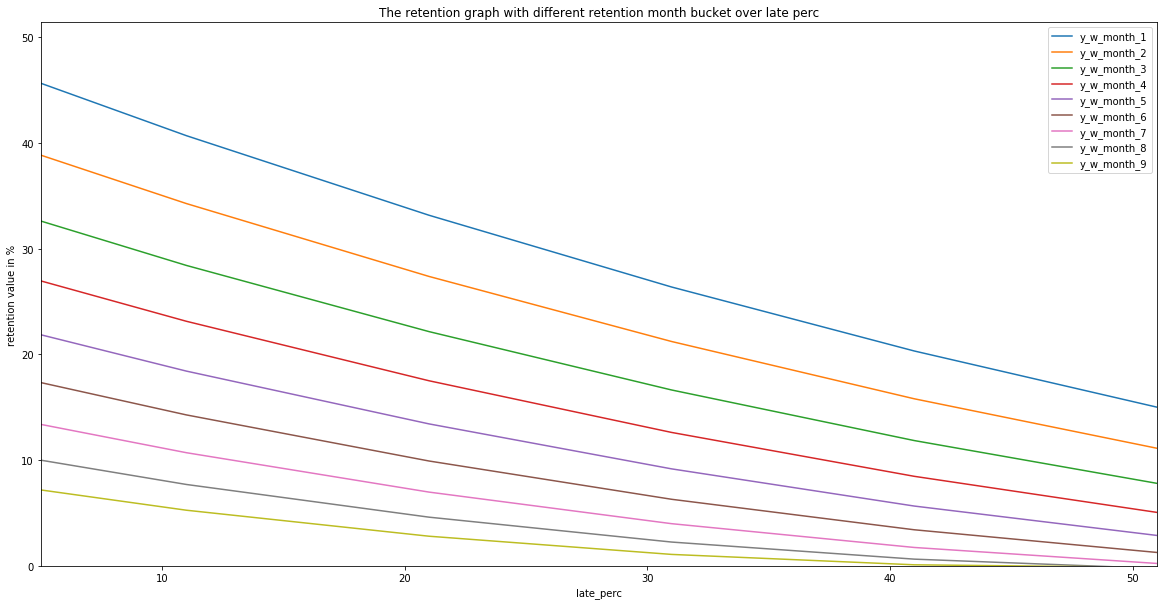

In [1476]:
#set up the groups
month =  list(np.arange(1, 10, 1))
y_name = ['y_w_month_' + str(i) for i in month]

#initiate the DF
df_simulated = pd.DataFrame(columns=y_name)

# x axis is late
df_simulated['x'] = list(np.arange(1, 60, 10))

ttd = 20

# X['sqrt_rentention_month_bucket'] = np.sqrt(X['rentention_month_bucket'])

for i,c in zip(month,y_name):

    simulated_late_delivery_perc = df_simulated['x']
    simulated_month = [i]*len(simulated_late_delivery_perc)
    simulated_ttd = [ttd] *len(simulated_late_delivery_perc)

    X_df = pd.DataFrame(list(zip(simulated_late_delivery_perc,simulated_ttd,simulated_month)),columns=['late_mixed_delivery_perc_med','mixed_ttd_mean_bucket_med','retention_month_bucket'])
    df_simulated[c]=func_exp_d2(X_df, *popt_d2)

df_simulated.set_index('x',inplace=True)
df_simulated.plot(figsize=(20,10))
plt.xlabel('late_perc')
plt.ylabel('retention value in %')
plt.ylim(-0,)
plt.xlim(5,)
plt.title('The retention graph with different retention month bucket over late perc')